#######################################################################
# Teste técnico - Localiza -

Autor: Pedro Henrique Ribeiro dos Reis

Vaga: Cientista de dados

########################################################################

# Análise de Churn em Telecomunicações

## Contexto do Problema

Uma empresa de telecomunicações possui uma base de dados com **7.043 clientes** e **48 variáveis** contendo informações demográficas, contratuais, de serviços e comportamentais.

O objetivo principal é **prever quais clientes têm maior probabilidade de deixar a empresa (churn)**, possibilitando a criação de ações preventivas de retenção.

Focaremos em reduzir os falsos negativos RECALL ALTO, mas sem reduzir muito a PRECISÃO verdadeiro positivo.

___________________________________________________________________________

DEFINIÇÕES --



  PRECISÃO: De todas as vezes que o modelo previu algo como positivo, quantas estavam corretas?

  RECALL: De todos os casos que eram realmente positivos, quantos o modelo conseguiu encontrar?

obs: temos estas métricas para ambas as classes 0 e 1.

___________________________________________________________________________

## Dados Disponíveis

As variáveis podem ser agrupadas em quatro categorias principais:

### 1. **Informações Demográficas**
- Dados pessoais (gênero, idade, estado civil, dependentes)
- Localização (país, estado, cidade, CEP, coordenadas geográficas)

### 2. **Informações de Serviços**
- Serviços contratados (telefonia, internet, TV, streaming)
- Planos e ofertas (tipo de contrato, ofertas promocionais)
- Métodos de pagamento e faturamento

### 3. **Informações Financeiras**
- Fatura mensal (média e totais)
- Receitas, reembolsos e fatura extras
- Histórico de pagamentos

### 4. **Variáveis de Churn**

Esta é a variável resposta:
- **Churn Label**: Yes/No (classificação binária)

___________________________________________________________________________

Já estas não serão utilizadas no modelo evitando o data Leakege)
Um modelo nunca pode ter informções do futuro nem da base de teste!
Outro ponto muito importante, se estamos criando um modelo para produção temos que pensar em quais são as variáveis que estarão disponíveis na produção!!!

___________________________________________________________________________

- **Customer Status**: Churned, Stayed, Joined (variável alvo)
- **Churn Score**: Pontuação preditiva (0-100)
- **Churn Category & Reason**: Categorias e motivos específicos

## Objetivo do Projeto

Desenvolver um **modelo de classificação** que identifique clientes propensos ao churn com base em suas características e comportamento. O modelo será utilizado para:

1. **Identificar** clientes em risco de cancelamento
2. **Entender** os principais fatores que influenciam o churn
3. **Priorizar** acionáveis de retenção
4. **Otimizar** recursos de marketing, serviço e atendimento

## Desafios a Serem Enfrentados

1. **Tratamento de dados**: Lidar com valores ausentes, outliers e inconsistências
2. **Engenharia de features**: Criar variáveis relevantes a partir dos dados existentes
3. **Desequilíbrio de classes**: Provável distribuição desigual entre clientes que fazem e não fazem churn
4. **Seleção de modelo**: Escolher o algoritmo mais adequado considerando interpretabilidade e performance
5. **Validação**: Garantir que o modelo generalize bem para novos dados

## Métricas de Sucesso Esperadas

- **Alta precisão** na identificação de clientes em risco
- **Bom recall** para minimizar falsos negativos (clientes que churnam não identificados)
- **Interpretabilidade** do modelo para ações comerciais
- **Validação robusta** através de métricas como RECALL, PRECISÃO. AUC-PR, F1-score e matriz de confusão com pontos de corte alteráceis para melhor escolha do trade off entre recall e precisão.


#Instalando algumas as bibliotecas no google colab

In [1]:
# instala as bibliotecas
!pip install xgboost
!pip install lightgbm
!pip install catboost

!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.5 MB/s eta 0:00:00


#Importando todas as bibliotecas que serão utilizadas no projeto

In [2]:
#Libs
# manipulação de dados
import pandas as pd
import numpy as np
import unicodedata

# testes estatísticos
import scipy.stats as stats
from scipy.stats import chi2_contingency

# tratamento de outliers
from scipy.stats.mstats import winsorize

# visualização
import matplotlib.pyplot as plt
import seaborn as sns

# separação entre treino/validação e teste, escolha do melhor algoritmo na fase de validação e tunning
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold

# criação de pipeline de tratamento de dados
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# funções de tratamento
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder

# modelos que irão competir com base nas métricas mais compatíveis com o problema do projeto
# por se tratar de churn (evento 'raro') UTILIZAREMOS O RECALL COM MÉTRICA NORTEADORA juntamento com o F1

# modelo de classificação linear generalizado
from sklearn.linear_model import LogisticRegression
# método emsemble de bagging (árvores utilizadas em paralelo - bom para reduzir a variância, pois utiliza votação de todos os modelos)
from sklearn.ensemble import RandomForestClassifier
# método ensemble de boosting( árvores treinadas em sequência - reduz o viés, pois os modelos corrigem os erros dos anteriores)
from xgboost import XGBClassifier
# método de boosting também, mas é mais eficiente para bases muito grande, pois a construção das árvores não é simétrica
from lightgbm import LGBMClassifier
# também de boosting e não precisa de ter um pipeline de tratamento de variáveis categóricas!
from catboost import CatBoostClassifier


# métricas de avaliação dos modelos
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix,\
 classification_report, auc, roc_auc_score, roc_curve, precision_recall_curve
import shap

# Transformer customizado sklearn para usar dentro do Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

#Funções próprias a serem utilizadas na análise descritiva - fora do pipeline

In [ ]:
# renomeia colunas
def renomear_colunas(df, mapa_colunas):
  # evita a alteração no dataframe original sem autorização
    df = df.copy()
    return df.rename(columns=mapa_colunas)

In [ ]:
# trata texto
def strings_para_minusculas(x):
    if isinstance(x, pd.Series):
        s = x.copy()
        # aplica transformações apenas nos valores não nulos
        s = s.where(
            # condição onde é NaN mantém como está
            s.isna(),
            # senão, aplica transformações
            s.astype(str).str.strip().str.lower()
        )
        return s

    elif isinstance(x, pd.DataFrame):
        df = x.copy()
        colunas = df.select_dtypes(include=['object', 'string']).columns

        for col in colunas:
            df[col] = df[col].where(
                df[col].isna(),
                df[col].astype(str).str.strip().str.lower()
            )

        return df

    else:
        raise TypeError(
            "strings_para_minusculas aceita apenas pandas Series ou DataFrame"
        )

In [ ]:
# replace para valores específicos
def replace_por_coluna(df, regras):

    df = df.copy()

    for coluna, mapeamento in regras.items():
        if coluna not in df.columns:
            raise ValueError(f"Coluna '{coluna}' não encontrada no DataFrame")

        df[coluna] = df[coluna].replace(mapeamento)

    return df

Função para tratamento de outliers, eu optei por trocar os valores extremos pelos valores dos limites inferiores e superiores

In [ ]:
# substitui outliers pelos valores dos limites
def replace_outliers_iqr(x, k=1.5):

    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    return x.clip(lower=lower_bound, upper=upper_bound)

já esta função apenas retorna os limites superiores e inferiores das variáveis numéricas

In [ ]:
# identifica os limites inferior e superior
def limites(x, k=1.5):

    Q1 = X.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    return lower_bound, upper_bound

In [ ]:
# função resumo do dataframe
def resumo_dataframe(df):

    print(f"Shape: {df.shape}\n\n\n")
    summary = pd.DataFrame({
        'Colunas': df.columns,
        'Dtypes': df.dtypes.values,
        'Missing_n': df.isnull().sum().values,
        'Missing_%': df.isnull().mean(),
        'Val_unicos': df.nunique().values,
    })
    return summary.sort_values(by='Missing_%', ascending=False).reset_index(drop=True)

In [ ]:
# verifica a quantidade de linhas duplicadas
def verificar_duplicados(df):

    df = df.copy()

    n_duplicados = df.duplicated().sum()
    perc_duplicados = n_duplicados / len(df)

    return print(f'Qnt_duplicados: {n_duplicados} \n\n Perc_duplicados: {perc_duplicados}')

In [ ]:
# ordena pelo maior percentual de valores NA e remove as variáveis com mais de 20% de NA
def remover_colunas_com_muitos_nulos(df, limite=0.2):

    df = df.copy()
    # proporção de valores nulos por coluna
    proporcao_nulos = df.isnull().mean()
    # colunas acima do limite
    colunas_para_remover = proporcao_nulos[proporcao_nulos > limite].sort_values(ascending=False)
    dados = df.drop(columns=colunas_para_remover.index)

    return colunas_para_remover, dados

In [ ]:
# recodifica as categorias das variáveis
def recodificar_colunas(df, mapeamentos, inplace=False):

    if not inplace:
        df = df.copy()
    for col, mapa in mapeamentos.items():
        if col in df.columns:
            df[col] = df[col].map(mapa)
        else:
            print(f"Aviso: coluna '{col}' não encontrada no DataFrame.")

    return df

Teste Qui quadrado não é paramétrico ele utiliza apenas as frequências observadas e esperadas e não é afetado por outliers

In [ ]:
# função testes Qui2, temos uma amostra suficientemente grande para o teste > 20
def Qui2(df, lista_variaveis, target='Churn Label', alpha=0.05):

    resultados = []

    for var in lista_variaveis:
        # cria a tabela de contingência
        contingencia = pd.crosstab(df[target], df[var])
        # executa a estatística de teste
        chi2, p, dof, expected = chi2_contingency(contingencia)
        # determina a hipótese
        status = "DEPENDENTE (H1)" if p < alpha else "INDEPENDENTE (H0)"
        influencia = "Sim" if p < alpha else "Não"
        # guarda resultados para um DataFrame consolidado
        resultados.append({
            'Variável': var,
            'Chi2': round(chi2, 4),
            'p-valor': round(p, 4),
            'Status': status,
            'Influencia Churn?': influencia
        })
    # cria dataframe de resultados para fácil leitura
    df_resumo = pd.DataFrame(resultados).sort_values(by='p-valor')

    return df_resumo

Escolhi o teste de Mann Whitney por se tratar de um teste robusto a outliers por utilizar a mediana e por ser não paramétrico, por exemplo não depende da normalidade dos dados.

In [ ]:
# Teste de Mann Whitney uma opção de teste estatístico para média robusto a ouutliers
def mannwhitney(
    df,
    lista_numericas,
    target='Churn Label',
    alpha=0.05,
    # teste bilateral pega tanto os valores extremos superiorres quanto os inferiores (divide o alfa de 5% em dois)
    alternative='two-sided'
):
    resultados = []

    # preparação do Target: converte para 0 e 1
    target_series = df[target].map({
        'yes': 1, 'no': 0,
        'Yes': 1, 'No': 0,
        'Sim': 1, 'Não': 0,
        1: 1, 0: 0
    })
    # remove linhas com a variável resposta ausente
    mask_valid_target = target_series.notna()

    for col in lista_numericas:
        try:
            # garante que a coluna seja numérica
            dados_col = pd.to_numeric(
                df.loc[mask_valid_target, col],
                errors='coerce'
            )
            target_col = target_series[mask_valid_target]
            # remove os valores NaNs
            valid_mask = dados_col.notna()
            final_num = dados_col[valid_mask]
            final_target = target_col[valid_mask]
            # separa grupos
            grupo_a = final_num[final_target == 1]
            grupo_b = final_num[final_target == 0]
            # Mann Whitney exige pelo menos 1 valor em cada grupo
            if len(grupo_a) < 2 or len(grupo_b) < 2:
                continue
            # estatística de teste
            u_stat, p_valor = stats.mannwhitneyu(
                grupo_a,
                grupo_b,
                alternative=alternative
            )
            # correlação ponto-biserial via ranks (efeito)
            ranks = stats.rankdata(final_num)
            corr_pb, _ = stats.pointbiserialr(final_target, ranks)
            abs_corr = abs(corr_pb)

            # classificação da intensidade
            if abs_corr < 0.1:
                intensidade = "Desprezível"
            elif abs_corr < 0.3:
                intensidade = "Baixa"
            elif abs_corr < 0.5:
                intensidade = "Moderada"
            else:
                intensidade = "Forte"

            resultados.append({
                'Variável': col,
                'p-valor': round(p_valor, 4),
                'Correlação (PB ranks)': round(corr_pb, 4),
                'Intensidade': intensidade,
                'Influencia Churn?': "Sim" if p_valor < alpha else "Não"
            })

        except Exception as e:
            print(f"Erro ao processar a coluna {col}: {e}")

    df_resumo = (
        pd.DataFrame(resultados)
        .sort_values(by='p-valor')
        .reset_index(drop=True)
    )

    return df_resumo


Método de V Cramer  para medir a intesidade das relações entre as variáveis categóricas

In [ ]:
# função analisar_intensidade_chi2 realiza o teste Qui-Quadrado e calcula o V de Cramer para medir a intensidade da associação entre variáveis
def analisar_intensidade_chi2(df, lista_variaveis, target='Churn Label', alpha=0.05):

    resultados = []

    for var in lista_variaveis:
        # Tabela de contingência
        contingencia = pd.crosstab(df[target], df[var])
        # Qui-Quadrado
        chi2, p, dof, expected = chi2_contingency(contingencia)
        # cálculo do V de Cramer
        n = contingencia.sum().sum()
        phi2 = chi2 / n
        r, k = contingencia.shape
        # correção para o v de Cramer
        v_cramer = np.sqrt(phi2 / min(r - 1, k - 1))
        # interpreta a ntensidade (Regra de Bolso)
        if v_cramer < 0.1:
            intensidade = "Desprezível"
        elif v_cramer < 0.3:
            intensidade = "Fraco"
        elif v_cramer < 0.7:
            intensidade = "Moderada"
        else:
            intensidade = "Forte"

        resultados.append({
            'Variável': var,
            'p-valor': round(p, 4),
            'V de Cramer': round(v_cramer, 4),
            'Intensidade': intensidade,
            'Influencia Churn?': "Sim" if p < alpha else "Não"
        })

    df_resumo = pd.DataFrame(resultados).sort_values(by='V de Cramer', ascending=False)
    return df_resumo

#Importando os dados

In [ ]:
# importando o banco de dados
caminho = '/content/drive/MyDrive/Colab Notebooks/Dados/telco_v2.csv'
dados_brutos = pd.read_csv(caminho)

# identificando o tipo das variáveis
dados_brutos.head().T.assign(dtype=dados_brutos.dtypes)

,0,1,2,3,4,dtype
Customer ID,8779-QRDMV,7495-OOKFY,1658-bygoy,4598-XLKNJ,4846-WHAFZ,object
Gender,Male,female,male,Female,Female,object
Age,78.0,74.0,71.0,78.0,80.0,float64
Married,No,yes,NO,yes,YES,object
Dependents,no,yes,yes,Yes,YES,object
Number of Dependents,0.0,1.0,3.0,1.0,1.0,float64
Country,United States,UNITED STATES,United States,UNITED STATES,United States,object
State,California,California,california,California,California,object
City,los angeles,Los Angeles,Los Angeles,Inglewood,WHITTIER,object
Zip Code,90022.0,90063.0,90065.0,90303.0,NaN,float64


Cria um cópia dos dados brutos para ser utilizada na análise descritiva.


Evita o comprometimento da dase bruta por alterações ('backup')

In [ ]:
# realiza uma cópia dos dados brutos como o nome de dados descritiva
dados_descritiva = dados_brutos.copy()
dados_descritiva.head()

,Customer ID,Gender,Age,Married,Dependents,Number of Dependents,Country,State,City,Zip Code,...,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Label,Churn Score,Churn Category,Churn Reason
0,8779-QRDMV,Male,78.0,No,no,0.0,United States,California,los angeles,90022.0,...,39.65,0.00,20.0,0.00,59.65,churned,yes,91.0,Competitor,Competitor offered more data
1,7495-OOKFY,female,74.0,yes,yes,1.0,UNITED STATES,California,Los Angeles,90063.0,...,633.30,0.00,0.0,390.80,1024.10,Churned,Yes,69.0,Competitor,Competitor made better offer
2,1658-bygoy,male,71.0,NO,yes,3.0,United States,california,Los Angeles,90065.0,...,8739.55,45.61,0.0,203.94,1910.88,Churned,Yes,81.0,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78.0,yes,Yes,1.0,UNITED STATES,California,Inglewood,90303.0,...,2514.50,13.43,0.0,494.00,2995.07,Churned,yes,88.0,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80.0,YES,YES,1.0,United States,California,WHITTIER,NaN,...,2868.15,0.00,0.0,234.21,3102.36,Churned,Yes,67.0,Price,Extra data charges


In [ ]:
# aplica a função resumo_dataframe
resumo_dataframe(dados_descritiva)

Shape: (7043, 48)





,Colunas,Dtypes,Missing_n,Missing_%,Val_unicos
0,Churn Reason,object,5174,0.734630,20
1,Churn Category,object,5174,0.734630,5
2,Offer,object,2538,0.360358,17
3,Internet Type,object,964,0.136873,10
4,Age,float64,40,0.005679,131
5,Monthly Charge,float64,38,0.005395,1652
6,Number of Referrals,float64,37,0.005253,80
7,Longitude,float64,36,0.005111,1697
8,Total Long Distance Charges,float64,35,0.004969,6066
9,Latitude,float64,35,0.004969,1682


# Dando uma olhada nos motivos que fizeram os clientes cancelarem os serviços
Esta variável se trata do futuro! não podemos utilizá-la no modelo (data leakege).

O modelo é feito para o ambiente de produção! temos que utilizar variáveis acessiveis.

Nesta etapa estamos apenas buscando entender melhor a distribuição dos motivos dos
cancelamentos.

In [ ]:
# dataframe contendo os motivos de cancelamento
df_motivos = dados_descritiva['Churn Reason'].value_counts().reset_index()
df_motivos.columns = ['Motivo', 'Contagem']
df_motivos = df_motivos.sort_values('Contagem', ascending=True)
df_motivos

NameError: name 'dados_descritiva' is not defined

<Figure size 320x240 with 0 Axes>

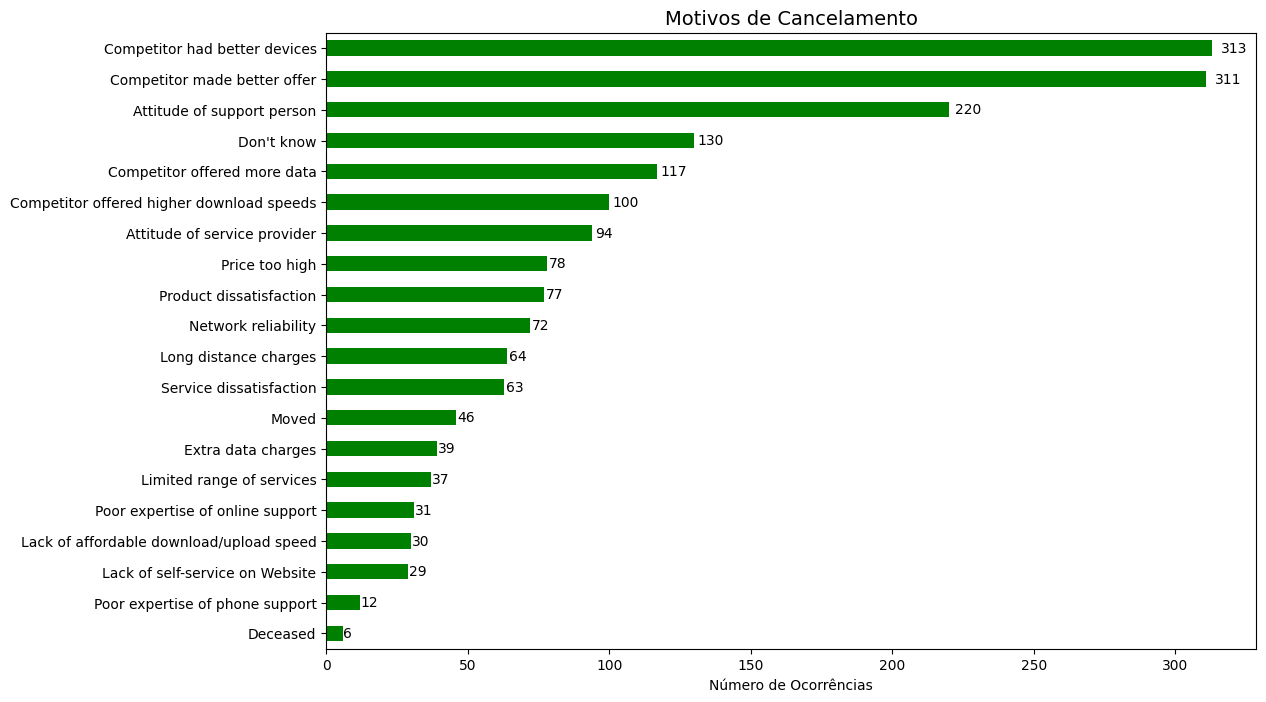

In [ ]:
# gráfico dos motivos de cancelamento
plt.figure(dpi=50)
ax = df_motivos.plot.barh(
    x='Motivo',
    y='Contagem',
    color='green',
    legend=False,
    figsize=(12, 8)
)

plt.title('Motivos de Cancelamento', fontsize=14)
plt.xlabel('Número de Ocorrências')
plt.ylabel('')

# adiciona o rótulos de dados nas barras
for i, (bar, v) in enumerate(zip(ax.patches, df_motivos['Contagem'])):
    ax.text(bar.get_width() + 0.01*v, bar.get_y() + bar.get_height()/2,
           f'{v:,}', va='center')

plt.show()

Verificando o tipo das variáveis e alguns valores das categorias

In [ ]:
# identificando o tipo das variáveis (ultima coluna dtype)
dados_descritiva.head().T.assign(dtype=dados_descritiva.dtypes)

,0,1,2,3,4,dtype
Customer ID,8779-QRDMV,7495-OOKFY,1658-bygoy,4598-XLKNJ,4846-WHAFZ,object
Gender,Male,female,male,Female,Female,object
Age,78.0,74.0,71.0,78.0,80.0,float64
Married,No,yes,NO,yes,YES,object
Dependents,no,yes,yes,Yes,YES,object
Number of Dependents,0.0,1.0,3.0,1.0,1.0,float64
Country,United States,UNITED STATES,United States,UNITED STATES,United States,object
State,California,California,california,California,California,object
City,los angeles,Los Angeles,Los Angeles,Inglewood,WHITTIER,object
Zip Code,90022.0,90063.0,90065.0,90303.0,NaN,float64


O texto das categorias das variáveis categoricas precisa ser padronizado

Existem várias versões de texto para uma mesma categoria exemplo abaixo

In [ ]:
dados_descritiva['Contract'].value_counts()

,count
Contract,
Month-to-Month,2313
Two Year,1194
One Year,975
month-to-month,734
MONTH-TO-MONTH,563
two year,398
one year,307
TWO YEAR,291
ONE YEAR,268


#Limpando a base descritiva

In [ ]:
# aplica a função strings_para_minusculas
dados_descritiva = strings_para_minusculas(dados_descritiva)
dados_descritiva.head().T.assign(dtype=dados_descritiva.dtypes)

,0,1,2,3,4,dtype
Customer ID,8779-qrdmv,7495-ookfy,1658-bygoy,4598-xlknj,4846-whafz,object
Gender,male,female,male,female,female,object
Age,78.0,74.0,71.0,78.0,80.0,float64
Married,no,yes,no,yes,yes,object
Dependents,no,yes,yes,yes,yes,object
Number of Dependents,0.0,1.0,3.0,1.0,1.0,float64
Country,united states,united states,united states,united states,united states,object
State,california,california,california,california,california,object
City,los angeles,los angeles,los angeles,inglewood,whittier,object
Zip Code,90022.0,90063.0,90065.0,90303.0,NaN,float64


In [ ]:
# verifica o desbalanceamento nos dados não modificados
contagem = dados_descritiva['Churn Label'].value_counts()
percentual = dados_descritiva['Churn Label'].value_counts(normalize=True) * 100

pd.DataFrame({
    'contagem': contagem,
    'percentual (%)': percentual.round(2)
})

,contagem,percentual (%)
Churn Label,,
no,5174,73.46
yes,1869,26.54


In [ ]:
# verifica a quantidade de valores faltantes em cada variável
print("\033[92m \n--------------Valores Absolutos--------------------\n", "\033[97m \n", dados_descritiva.isnull().sum().sort_values(ascending=False))
print("\033[92m \n--------------Valores Percentuais--------------------\n", "\033[97m \n", dados_descritiva.isnull().mean().sort_values(ascending=False))

 
--------------Valores Absolutos--------------------
  
 Churn Reason                         5174
Churn Category                       5174
Offer                                2538
Internet Type                         964
Age                                    40
Monthly Charge                         38
Number of Referrals                    37
Longitude                              36
Total Long Distance Charges            35
Latitude                               35
Total Extra Data Charges               34
Avg Monthly Long Distance Charges      34
Number of Dependents                   34
Total Refunds                          33
Avg Monthly GB Download                33
Population                             32
Tenure in Months                       32
Total Charges                          30
Churn Score                            29
Total Revenue                          29
Zip Code                               25
Referred a Friend                       0
Country           

In [ ]:
# aplica a função remover_colunas_com_muitos_nulos
colunas_removidas, dados_descritiva = remover_colunas_com_muitos_nulos(dados_descritiva, limite=0.2)
print("\033[92m \n--------------Colunas removidas--------------------\n", "\033[97m \n", colunas_removidas)

 
--------------Colunas removidas--------------------
  
 Churn Category    0.734630
Churn Reason      0.734630
Offer             0.360358
dtype: float64


In [ ]:
# aplica a função resumo_dataframe
resumo_dataframe(dados_descritiva)

Shape: (7043, 45)





,Colunas,Dtypes,Missing_n,Missing_%,Val_unicos
0,Internet Type,object,964,0.136873,4
1,Age,float64,40,0.005679,131
2,Monthly Charge,float64,38,0.005395,1652
3,Number of Referrals,float64,37,0.005253,80
4,Longitude,float64,36,0.005111,1697
5,Total Long Distance Charges,float64,35,0.004969,6066
6,Latitude,float64,35,0.004969,1682
7,Total Extra Data Charges,float64,34,0.004827,79
8,Avg Monthly Long Distance Charges,float64,34,0.004827,3635
9,Number of Dependents,float64,34,0.004827,88


In [ ]:
# remove colunas que não serão usadas no modelo
cols_remover = ['Zip Code', 'Customer ID', 'Churn Score', 'Customer Status', 'City', 'Country', 'State', 'Quarter', 'Latitude', 'Longitude']
dados_descritiva = dados_descritiva.drop(columns=cols_remover, axis=1)
dados_descritiva.shape

(7043, 35)

In [ ]:
# aplica a função converter_para_categoria

#cols_para_converter = ['hypertension', 'heart_disease']
#dados = converter_para_categoria(dados, cols_para_converter)

#verificando a conversão
#dados.info()

In [ ]:
# aplica a função renomear_colunas
dic_rename = {'Gender': 'sexo',
              'Age': 'idade'}

dados_descritiva = renomear_colunas(dados_descritiva, dic_rename)
dados_descritiva.head(2)

,sexo,idade,Married,Dependents,Number of Dependents,Population,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Label
0,male,78.0,no,no,0.0,68701.0,no,0.0,1.0,no,...,month-to-month,yes,bank withdrawal,39.65,39.65,0.0,20.0,0.0,59.65,yes
1,female,74.0,yes,yes,1.0,55668.0,yes,1.0,8.0,yes,...,month-to-month,yes,credit card,80.65,633.30,0.0,0.0,390.8,1024.10,yes


In [ ]:
# aplica a função replace_por_coluna
dic_replace = {
    'sexo': {
        'male': 'Masculino',
        'female': 'Feminino'
    }
}

dados_descritiva = replace_por_coluna(dados_descritiva, dic_replace)
dados_descritiva.head(2)

,sexo,idade,Married,Dependents,Number of Dependents,Population,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Label
0,Masculino,78.0,no,no,0.0,68701.0,no,0.0,1.0,no,...,month-to-month,yes,bank withdrawal,39.65,39.65,0.0,20.0,0.0,59.65,yes
1,Feminino,74.0,yes,yes,1.0,55668.0,yes,1.0,8.0,yes,...,month-to-month,yes,credit card,80.65,633.30,0.0,0.0,390.8,1024.10,yes


In [ ]:
# verifica e remove as linhas duplicadas
verificar_duplicados(dados_descritiva)
dados_descritiva = dados_descritiva.drop_duplicates()

Qnt_duplicados: 0 

 Perc_duplicados: 0.0


In [ ]:
# seleciona todas as variáveis numéricas e categóricas
num_cols = dados_descritiva.select_dtypes(include=['number', 'int64', 'float']).columns.tolist()

cat_cols = dados_descritiva.select_dtypes(exclude=['number', 'int64', 'float']).columns.tolist()
cat_cols.remove('Churn Label')

In [ ]:
# verificando se tudo rodou normalmente
resumo_dataframe(dados_descritiva[num_cols])

Shape: (7043, 16)





,Colunas,Dtypes,Missing_n,Missing_%,Val_unicos
0,idade,float64,40,0.005679,131
1,Monthly Charge,float64,38,0.005395,1652
2,Number of Referrals,float64,37,0.005253,80
3,Total Long Distance Charges,float64,35,0.004969,6066
4,Number of Dependents,float64,34,0.004827,88
5,Total Extra Data Charges,float64,34,0.004827,79
6,Avg Monthly Long Distance Charges,float64,34,0.004827,3635
7,Avg Monthly GB Download,float64,33,0.004686,117
8,Total Refunds,float64,33,0.004686,573
9,Population,float64,32,0.004544,1632


In [ ]:
# verificando se tudo rodou normalmente
teste = dados_descritiva[cat_cols]
teste.T.assign(dtype=dados_descritiva.dtypes)

,0,1,2,3,4,5,6,7,8,9,...,7034,7035,7036,7037,7038,7039,7040,7041,7042,dtype
sexo,Masculino,Feminino,Masculino,Feminino,Feminino,Feminino,Feminino,Masculino,Feminino,Feminino,...,Feminino,Masculino,Masculino,Feminino,Feminino,Masculino,Feminino,Feminino,Masculino,object
Married,no,yes,no,yes,yes,no,yes,yes,no,no,...,no,no,no,no,no,yes,yes,yes,no,object
Dependents,no,yes,yes,yes,yes,yes,yes,no,yes,yes,...,no,no,no,no,no,yes,yes,yes,no,object
Referred a Friend,no,yes,no,yes,yes,no,yes,yes,no,no,...,no,no,no,no,no,yes,yes,yes,no,object
Phone Service,no,yes,yes,yes,yes,yes,yes,no,yes,yes,...,yes,yes,yes,no,yes,yes,yes,no,yes,object
Multiple Lines,no,yes,yes,no,yes,yes,no,no,yes,no,...,no,no,no,no,no,yes,yes,no,no,object
Internet Type,dsl,fiber optic,fiber optic,fiber optic,fiber optic,fiber optic,fiber optic,dsl,fiber optic,fiber optic,...,none,fiber optic,fiber optic,cable,none,cable,fiber optic,dsl,fiber optic,object
Online Security,no,no,no,no,no,no,no,no,no,yes,...,no,no,no,no,no,yes,no,yes,yes,object
Online Backup,no,yes,no,yes,no,no,no,yes,no,no,...,no,no,no,yes,no,no,yes,no,no,object
Device Protection Plan,yes,no,no,yes,no,yes,no,yes,no,no,...,no,no,no,yes,no,yes,yes,no,yes,object


#Análise descritiva

#Gráficos - Histograma, Boxplot e Dispersão

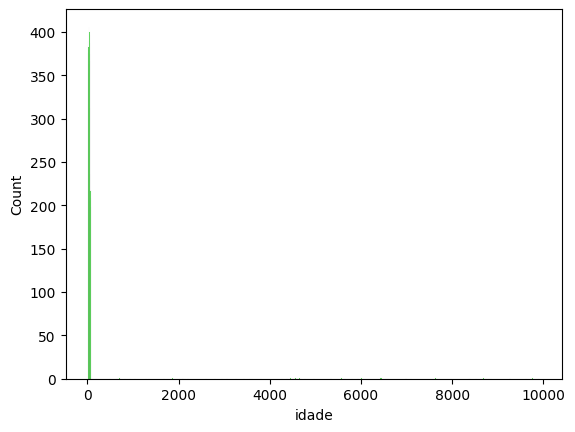

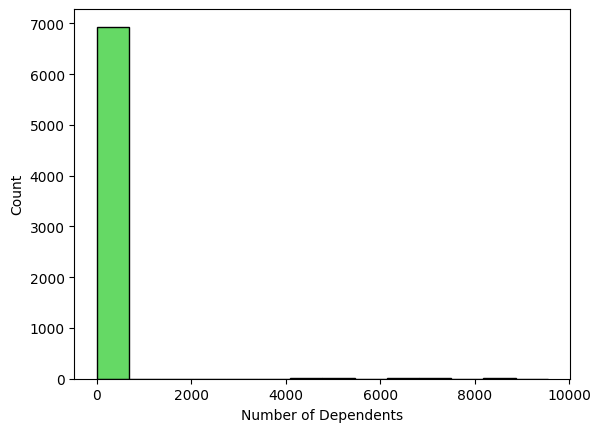

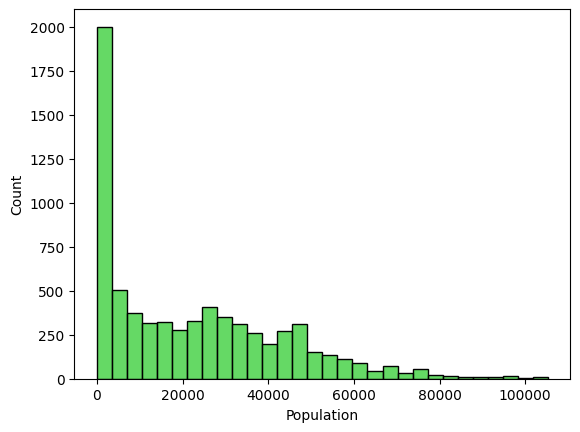

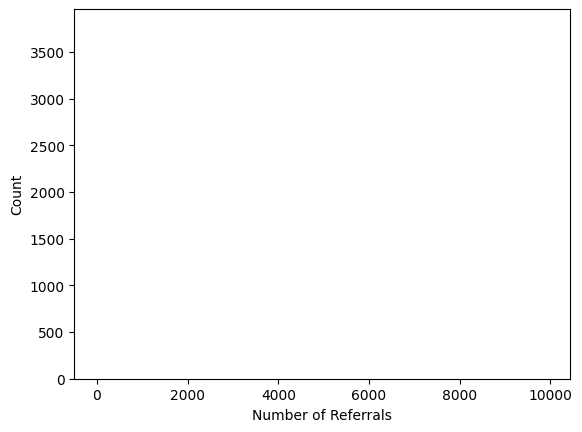

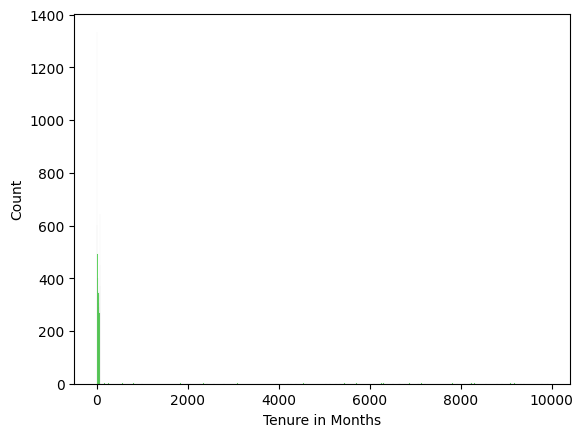

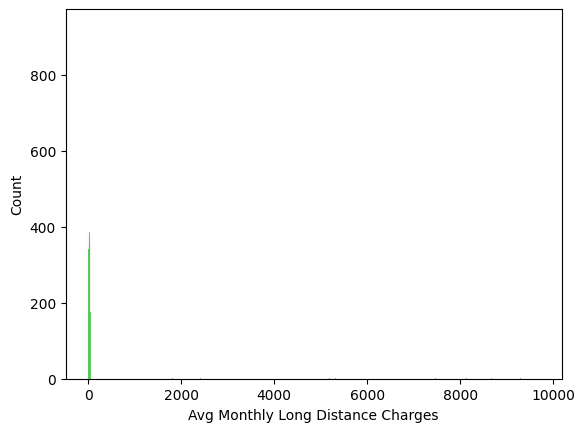

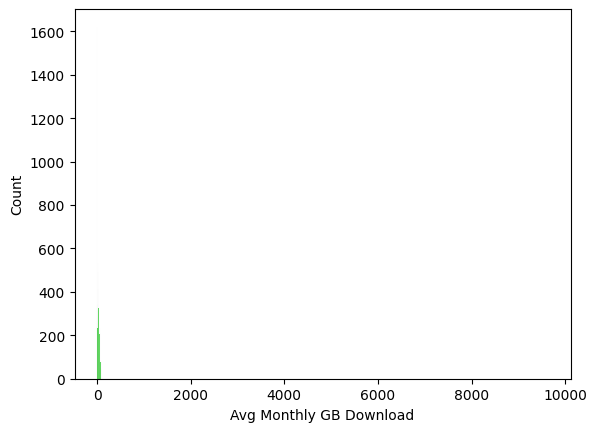

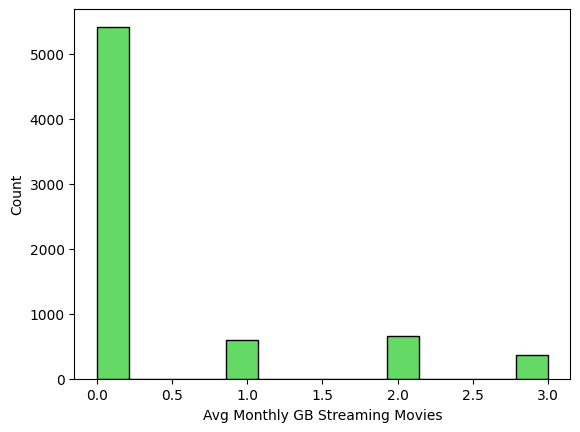

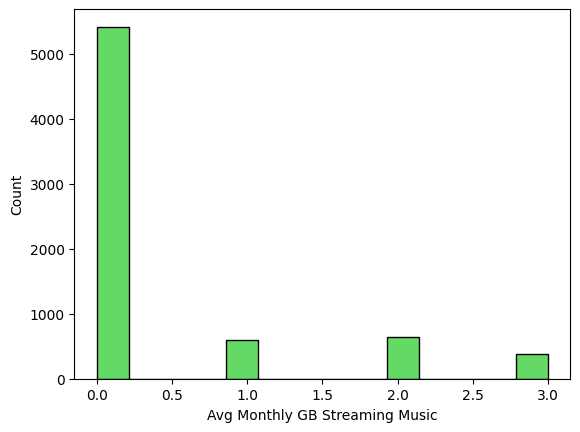

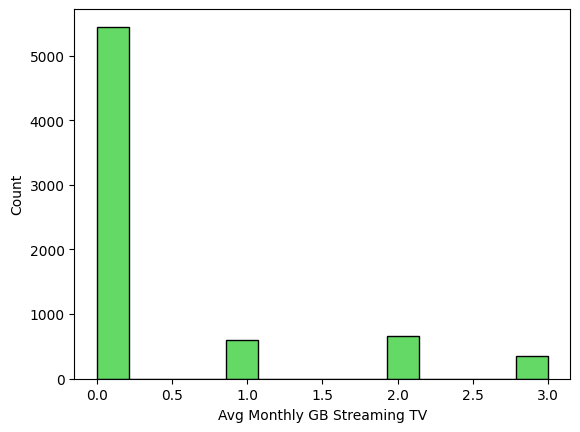

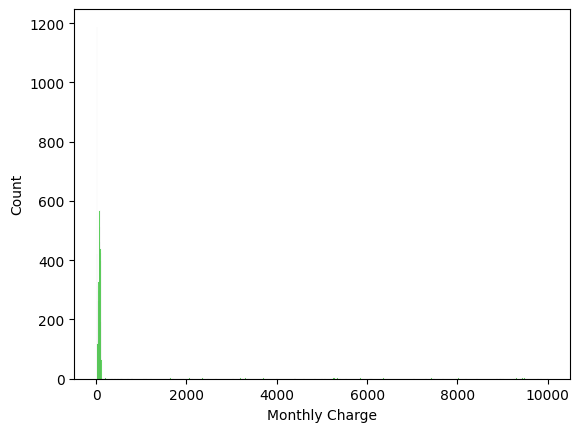

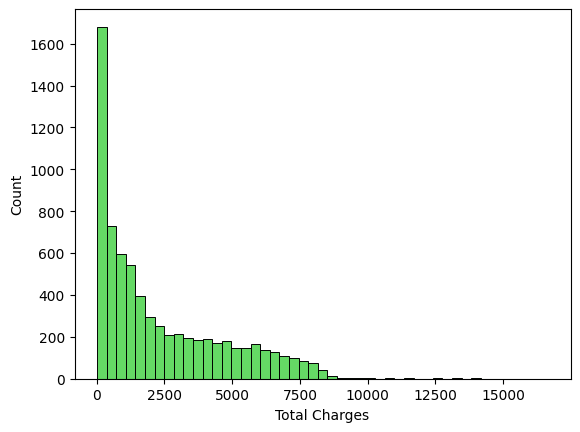

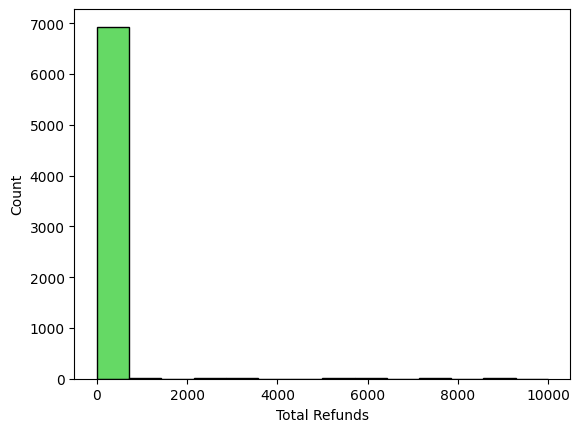

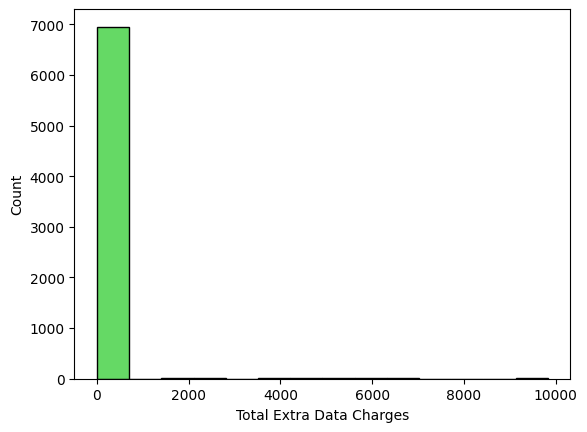

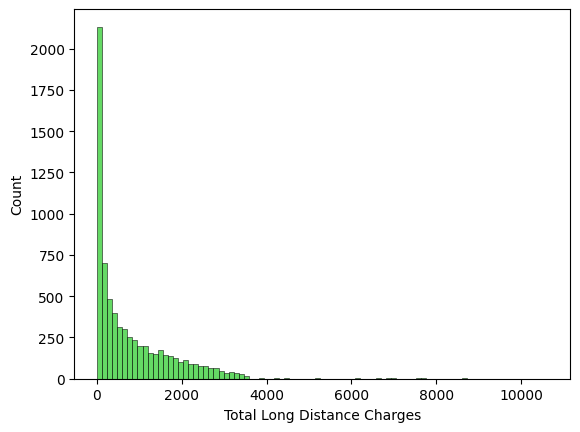

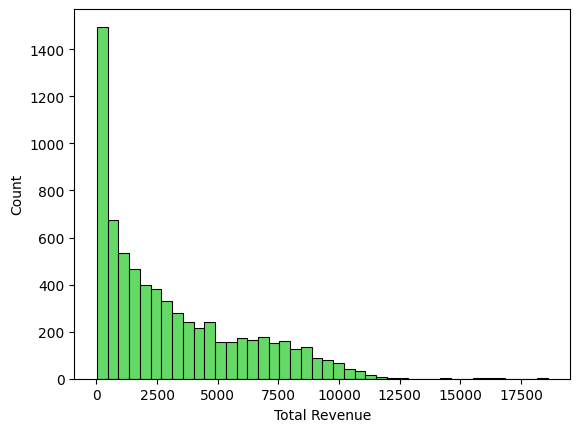

In [ ]:
# histograma para todas as variáveis numéricas
for i in dados_descritiva[num_cols]:
  sns.histplot(data=dados_descritiva, x=i, color='limegreen')
  plt.show()

In [ ]:
#avalia os valores máximos e mínimos das variáveis numéricas
pd.set_option('display.max_columns', None)
dados_descritiva.describe(include='all')

,sexo,idade,Married,Dependents,Number of Dependents,Population,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Avg Monthly GB Streaming Movies,Avg Monthly GB Streaming Music,Avg Monthly GB Streaming TV,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Label
count,7043,7003.000000,7043,7043,7009.000000,7011.000000,7043,7006.000000,7011.000000,7043,7009.000000,7043,6079,7010.000000,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043.000000,7043,7043,7043,7043,7005.000000,7013.000000,7010.000000,7009.000000,7008.000000,7014.000000,7043
unique,2,NaN,2,2,NaN,NaN,2,NaN,NaN,2,NaN,2,4,NaN,2,2,2,2,2,2,2,NaN,NaN,NaN,2,3,2,3,NaN,NaN,NaN,NaN,NaN,NaN,2
top,Masculino,NaN,no,no,NaN,NaN,no,NaN,NaN,yes,NaN,no,fiber optic,NaN,no,no,no,no,no,no,no,NaN,NaN,NaN,yes,month-to-month,yes,bank withdrawal,NaN,NaN,NaN,NaN,NaN,NaN,no
freq,3555,NaN,3641,5416,NaN,NaN,3821,NaN,NaN,6361,NaN,4072,3035,NaN,5024,4614,4621,4999,4336,4311,4555,NaN,NaN,NaN,4745,3610,4171,3909,NaN,NaN,NaN,NaN,NaN,NaN,5174
mean,NaN,93.329716,NaN,NaN,58.220859,22163.282556,NaN,45.994148,83.940807,NaN,72.133845,NaN,NaN,73.013980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.429788,0.431634,0.417862,NaN,NaN,NaN,NaN,113.265496,2335.464536,58.971673,48.008275,789.642837,3089.030676,NaN
std,NaN,543.182471,NaN,NaN,601.575489,21154.150823,NaN,519.690378,590.009467,NaN,562.238515,NaN,NaN,583.751484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.864756,0.868509,0.850784,NaN,NaN,NaN,NaN,572.427272,2356.205392,605.528820,498.990015,974.146779,2916.963485,NaN
min,NaN,19.000000,NaN,NaN,0.000000,11.000000,NaN,0.000000,1.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,18.250000,18.800000,0.000000,0.000000,0.000000,21.360000,NaN
25%,NaN,32.000000,NaN,NaN,0.000000,2349.000000,NaN,0.000000,9.000000,NaN,9.330000,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,35.800000,407.050000,0.000000,0.000000,72.607500,619.702500,NaN
50%,NaN,46.000000,NaN,NaN,0.000000,17494.000000,NaN,0.000000,29.000000,NaN,23.180000,NaN,NaN,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,70.550000,1412.650000,0.000000,0.000000,413.370000,2160.355000,NaN
75%,NaN,60.000000,NaN,NaN,0.000000,36137.000000,NaN,3.000000,56.000000,NaN,36.710000,NaN,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,90.250000,3856.750000,0.000000,0.000000,1228.132500,4887.487500,NaN


In [ ]:
# selecinando todas as variáveis realmente numéricas (unique do describe = NaN)
cols_unique_nan = (
    dados_descritiva.describe(include='all')
         .loc['unique']
         .isna()
)
variaveis_com_unique_nan = cols_unique_nan[cols_unique_nan].index.tolist()
variaveis_com_unique_nan

['idade',
 'Number of Dependents',
 'Population',
 'Number of Referrals',
 'Tenure in Months',
 'Avg Monthly Long Distance Charges',
 'Avg Monthly GB Download',
 'Avg Monthly GB Streaming Movies',
 'Avg Monthly GB Streaming Music',
 'Avg Monthly GB Streaming TV',
 'Monthly Charge',
 'Total Charges',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue']

In [ ]:
#avalia os valores máximos e mínimos das variáveis numéricas
pd.set_option('display.max_columns', None)
dados_descritiva[variaveis_com_unique_nan].describe(include='all')

,idade,Number of Dependents,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Avg Monthly GB Streaming Movies,Avg Monthly GB Streaming Music,Avg Monthly GB Streaming TV,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,7003.000000,7009.000000,7011.000000,7006.000000,7011.000000,7009.000000,7010.000000,7043.000000,7043.000000,7043.000000,7005.000000,7013.000000,7010.000000,7009.000000,7008.000000,7014.000000
mean,93.329716,58.220859,22163.282556,45.994148,83.940807,72.133845,73.013980,0.429788,0.431634,0.417862,113.265496,2335.464536,58.971673,48.008275,789.642837,3089.030676
std,543.182471,601.575489,21154.150823,519.690378,590.009467,562.238515,583.751484,0.864756,0.868509,0.850784,572.427272,2356.205392,605.528820,498.990015,974.146779,2916.963485
min,19.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,21.360000
25%,32.000000,0.000000,2349.000000,0.000000,9.000000,9.330000,4.000000,0.000000,0.000000,0.000000,35.800000,407.050000,0.000000,0.000000,72.607500,619.702500
50%,46.000000,0.000000,17494.000000,0.000000,29.000000,23.180000,17.000000,0.000000,0.000000,0.000000,70.550000,1412.650000,0.000000,0.000000,413.370000,2160.355000
75%,60.000000,0.000000,36137.000000,3.000000,56.000000,36.710000,27.000000,0.000000,0.000000,0.000000,90.250000,3856.750000,0.000000,0.000000,1228.132500,4887.487500
max,9905.000000,9550.000000,105285.000000,9943.000000,9915.000000,9692.350000,9634.000000,3.000000,3.000000,3.000000,10001.800000,16652.150000,9995.000000,9831.000000,10635.400000,18605.550000


In [ ]:
# verificando observações com valores muito altos e com insconsistências
dados_descritiva.loc[dados_descritiva['Number of Referrals'] > 300]
dados_descritiva.loc[dados_descritiva['Number of Dependents'] > 10]
dados_descritiva.loc[(dados_descritiva['Referred a Friend'] == 'no') & (dados_descritiva['Number of Referrals'] > 0), 'Referred a Friend'].count()
dados_descritiva.loc[(dados_descritiva['Referred a Friend'] == 'no') & (dados_descritiva['Number of Referrals'] > 0)]
dados_descritiva.loc[(dados_descritiva['Referred a Friend'] == 'no') & (dados_descritiva['Number of Referrals'] > 0), 'Referred a Friend'].count()
dados_descritiva.loc[(dados_descritiva['Dependents'] == 'no') & (dados_descritiva['Number of Dependents'] > 0),]

,sexo,idade,Married,Dependents,Number of Dependents,Population,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Avg Monthly GB Streaming Movies,Avg Monthly GB Streaming Music,Avg Monthly GB Streaming TV,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Churn Label
71,Feminino,68.0,no,no,428.0,49968.0,no,0.0,11.0,yes,3.96,no,fiber optic,27.0,no,no,no,no,yes,yes,no,0,3,0,yes,month-to-month,no,bank withdrawal,89.70,1047.70,0.00,0.0,43.56,1091.26,yes
89,Feminino,77.0,no,no,6435.0,1219.0,no,0.0,2.0,yes,19.27,yes,fiber optic,18.0,no,no,no,no,yes,yes,no,0,0,1,yes,month-to-month,yes,bank withdrawal,93.85,170.85,0.00,0.0,38.54,209.39,yes
229,Masculino,75.0,no,no,9497.0,57146.0,no,0.0,5.0,yes,36.36,yes,fiber optic,12.0,no,yes,no,no,no,yes,no,0,0,0,yes,month-to-month,yes,bank withdrawal,89.80,502.60,0.00,0.0,181.80,684.40,yes
366,Masculino,78.0,yes,no,1221.0,42663.0,yes,1.0,16.0,yes,45.90,no,fiber optic,5.0,no,no,no,no,no,no,no,0,0,0,yes,month-to-month,yes,bank withdrawal,71.80,1167.80,0.00,0.0,734.40,5914.20,yes
407,Masculino,68.0,yes,no,8511.0,857.0,yes,1.0,27.0,no,0.00,no,dsl,25.0,no,no,no,no,no,yes,no,3,2,2,no,month-to-month,no,bank withdrawal,36.50,1032.00,0.00,30.0,0.00,1062.00,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6652,Masculino,35.0,no,no,8592.0,5654.0,no,0.0,17.0,yes,27.66,no,none,0.0,no,no,no,no,no,no,no,0,0,0,no,two year,no,credit card,19.15,343.45,28.63,0.0,470.22,785.04,no
6863,Masculino,31.0,no,no,6269.0,24180.0,no,0.0,52.0,yes,21.98,no,NaN,0.0,no,no,no,no,no,no,no,0,0,3,no,two year,no,credit card,19.65,1025.05,0.00,0.0,1142.96,2168.01,no
6905,Feminino,3811.0,no,no,5372.0,18735.0,no,0.0,4.0,yes,22.07,no,dsl,41.0,yes,no,no,no,no,no,no,0,0,0,yes,month-to-month,yes,bank withdrawal,50.55,235.65,0.00,0.0,88.28,323.93,no
7038,Feminino,30.0,no,no,5428.0,2182.0,no,0.0,72.0,yes,22.77,no,none,0.0,no,no,no,no,no,no,no,0,0,0,no,two year,yes,bank withdrawal,21.15,1419.40,19.31,0.0,1639.44,3039.53,no


In [ ]:
dados_descritiva['Number of Dependents'].max()

9550.0

In [ ]:
teste2 = replace_outliers_iqr(dados_descritiva['idade'])
teste2.max()

102.0

In [ ]:
# verificando a quantidade de cada suposto outlier por ingestão
print(dados_descritiva.loc[dados_descritiva['idade'] > 100, 'idade'].count())
print(dados_descritiva.loc[dados_descritiva['Number of Dependents'] > 10, 'Number of Dependents'].count())
#print(dados_descritiva.loc[dados_descritiva['Number of Referrals'] > 300, 'Number of Referrals'].count())
print(dados_descritiva.loc[dados_descritiva['Tenure in Months'] > 1200, 'Tenure in Months'].count())    # 1200 meses é igual a 100 anos como sendo cliente
#print(dados.loc[dados['Avg Monthly Long Distance Charges'] > 2000, 'Tenure in Months'].count())
#print(dados.loc[dados['Avg Monthly GB Download'] > 27, 'Avg Monthly GB Download'].count())
#print(dados.loc[dados['Avg Monthly GB Streaming Movies'] > 27, 'Avg Monthly GB Streaming Movies'].count())
#print(dados.loc[dados['Avg Monthly GB Streaming Music'] > 27, 'Avg Monthly GB Streaming Music'].count())
#print(dados.loc[dados['Avg Monthly GB Streaming TV'] > 27, 'Avg Monthly GB Streaming TV'].count())
#print(dados.loc[dados['Monthly Charge'] > 2000, 'Monthly Charge'].count())
#print(dados.loc[dados['Total Charges'] > 2000, 'Total Charges'].count())
#print(dados.loc[dados['Total Refunds'] > 2000, 'Total Refunds'].count())
#print(dados.loc[dados['Total Extra Data Charges'] > 2000, 'Total Extra Data Charges'].count())
#print(dados.loc[dados['Total Long Distance Charges'] > 2000, 'Total Long Distance Charges'].count())
#print(dados.loc[dados['Total Revenue'] > 2000, 'Total Revenue'].count())

69
78
60


In [ ]:
# inserindo valores faltantes para os supostos valores outliers
dados_descritiva.loc[dados_descritiva['idade'] > 100, 'idade'] = np.nan
dados_descritiva.loc[dados_descritiva['Number of Dependents'] > 10, 'Number of Dependents'] = np.nan
dados_descritiva.loc[dados_descritiva['Number of Referrals'] > 50, 'Number of Referrals'] = np.nan
dados_descritiva.loc[dados_descritiva['Tenure in Months'] > 1200, 'Tenure in Months'] = np.nan
#dados.loc[dados['Avg Monthly Long Distance Charges'] > 2000, 'Avg Monthly Long Distance Charges'] = np.nan
#dados.loc[dados['Avg Monthly GB Download'] > 36, 'Avg Monthly GB Download'] = np.nan
#dados.loc[dados['Avg Monthly GB Streaming Movies'] > 36, 'Avg Monthly GB Streaming Movies'] = np.nan
#dados.loc[dados['Avg Monthly GB Streaming Music'] > 36, 'Avg Monthly GB Streaming Music'] = np.nan
#dados.loc[dados['Avg Monthly GB Streaming TV'] > 36, 'Avg Monthly GB Streaming TV'] = np.nan
#dados.loc[dados['Monthly Charge'] > 36, 'Monthly Charge'] = np.nan
#dados.loc[dados['Total Charges'] > 36, 'Total Charges'] = np.nan
#dados.loc[dados['Total Refunds'] > 36, 'Total Refunds'] = np.nan
#dados.loc[dados['Total Extra Data Charges'] > 36, 'Total Extra Data Charges'] = np.nan
#dados.loc[dados['Total Long Distance Charges'] > 36, 'Total Long Distance Charges'] = np.nan
#dados.loc[dados['Total Revenue'] > 36, 'Total Revenue'] = np.nan

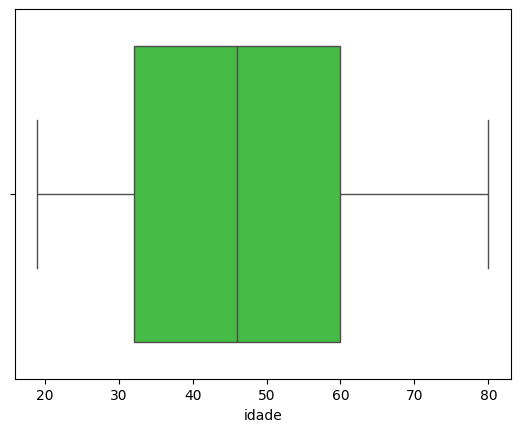

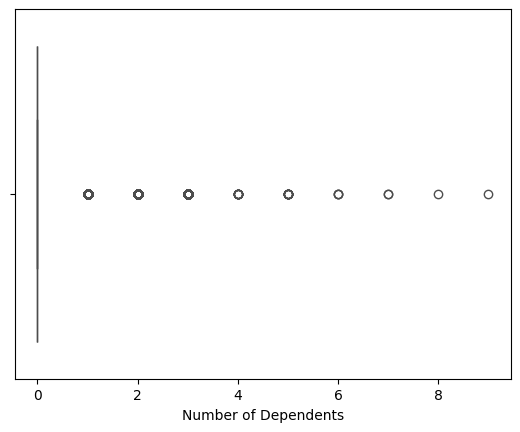

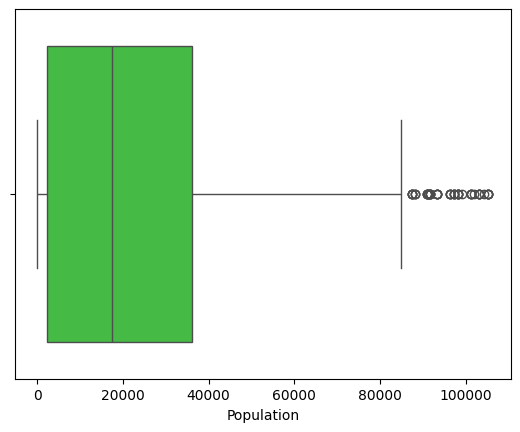

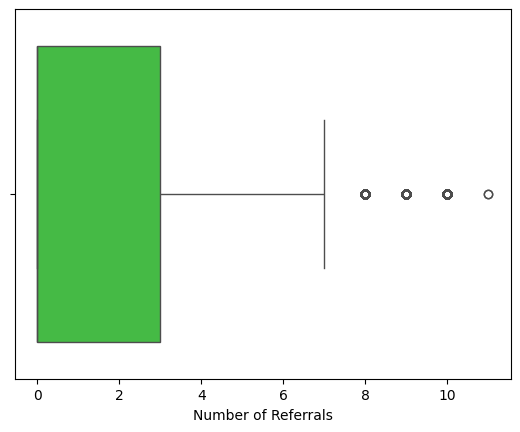

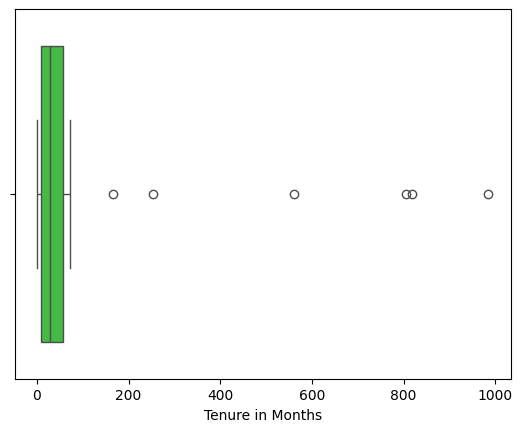

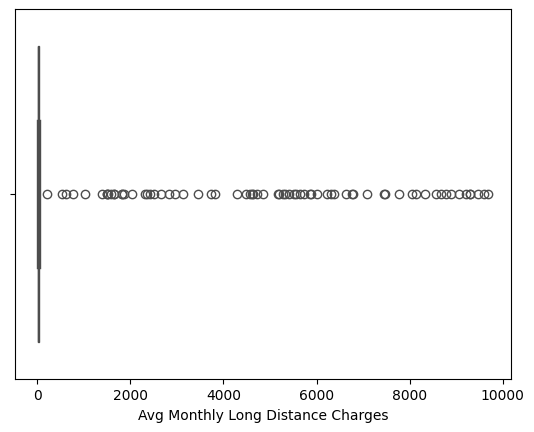

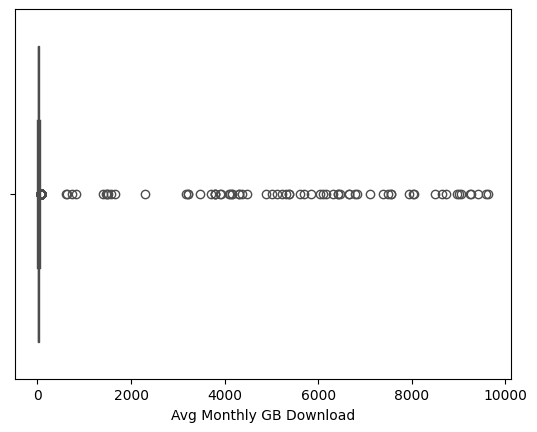

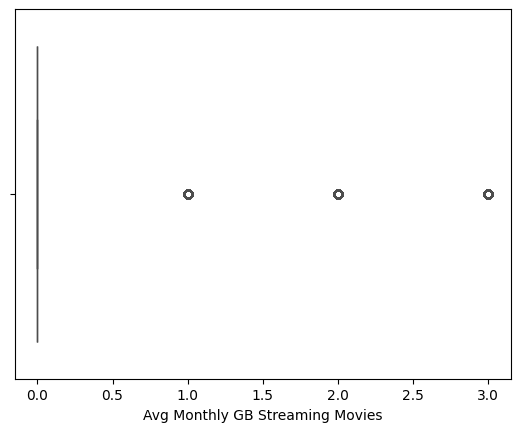

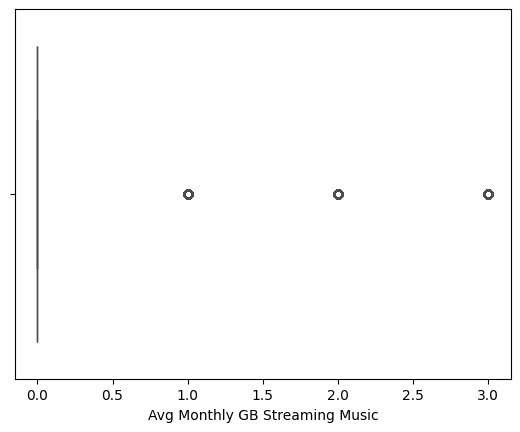

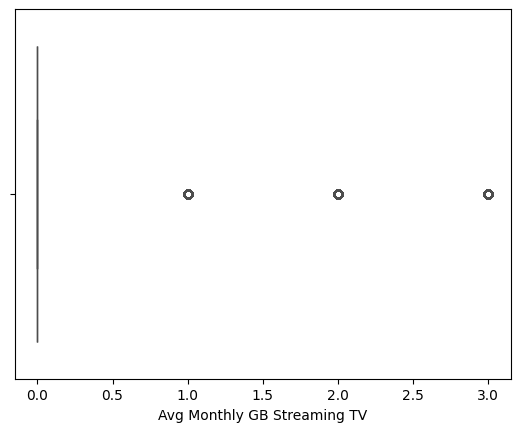

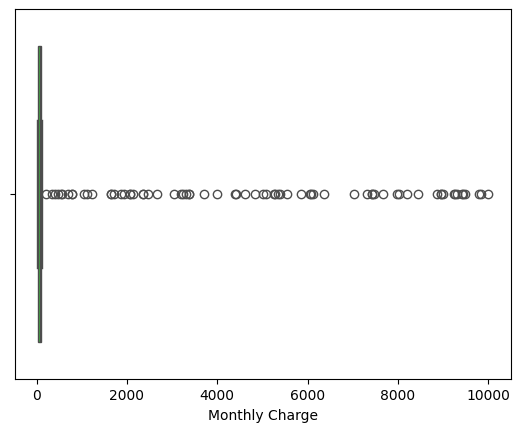

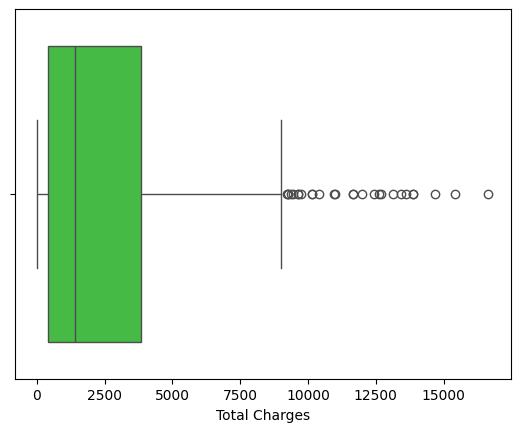

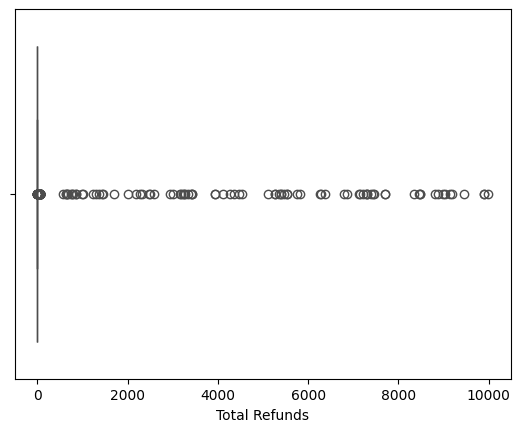

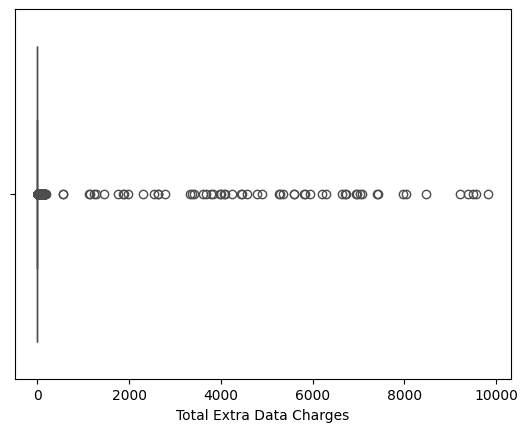

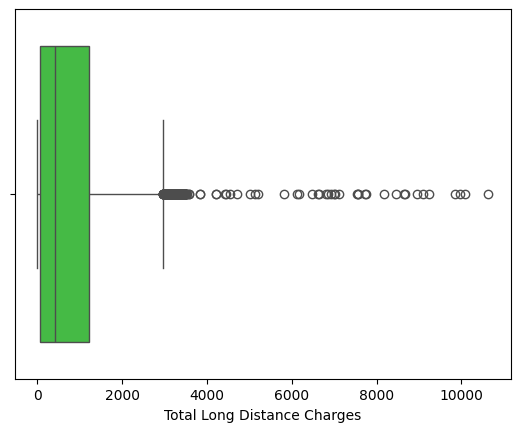

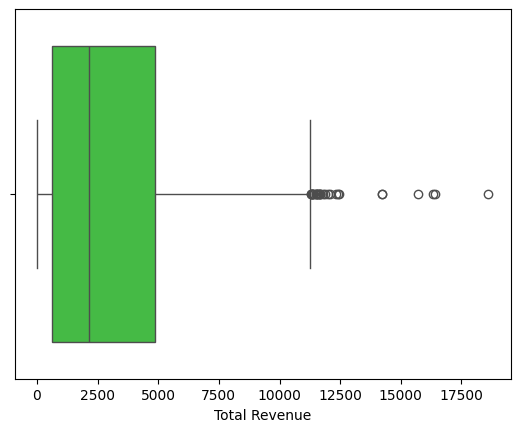

In [ ]:
#boxplot para múltiplas variáveis
for i in dados_descritiva[num_cols]:
  sns.boxplot(data=dados_descritiva, x=i, color= 'limegreen')
  plt.show()

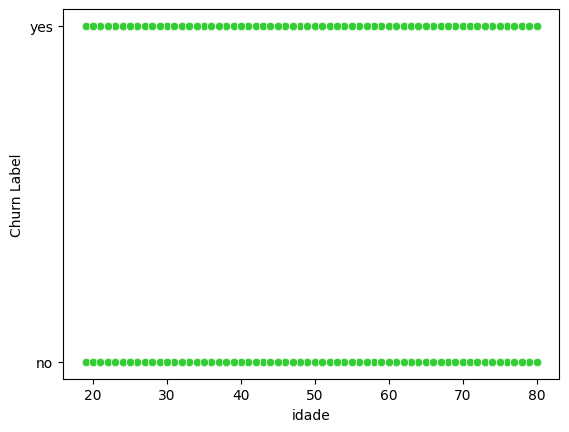

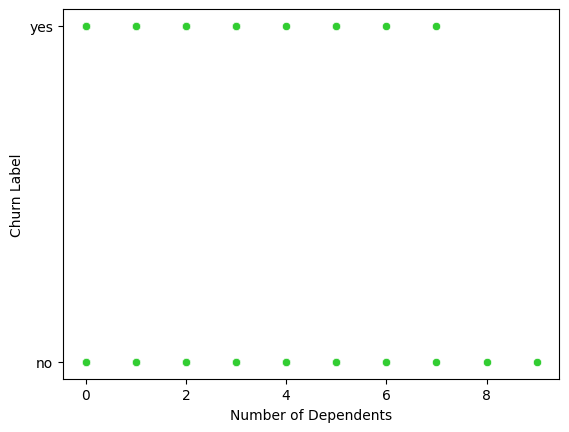

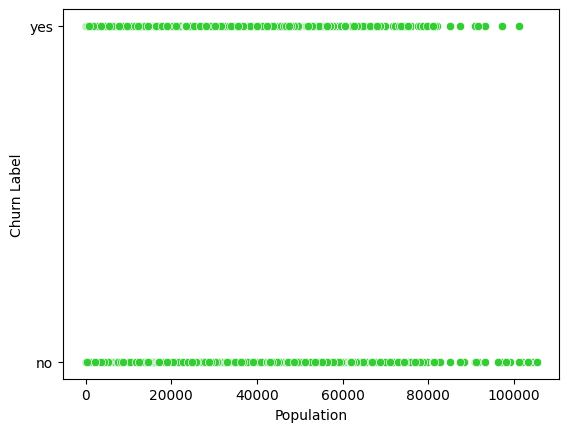

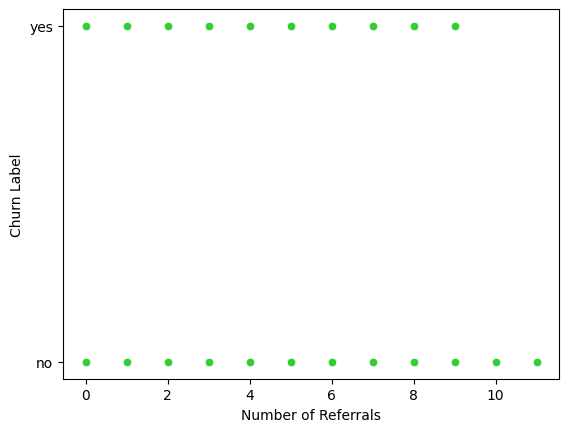

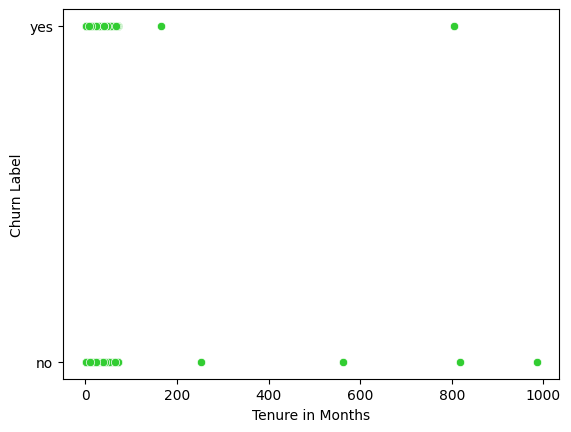

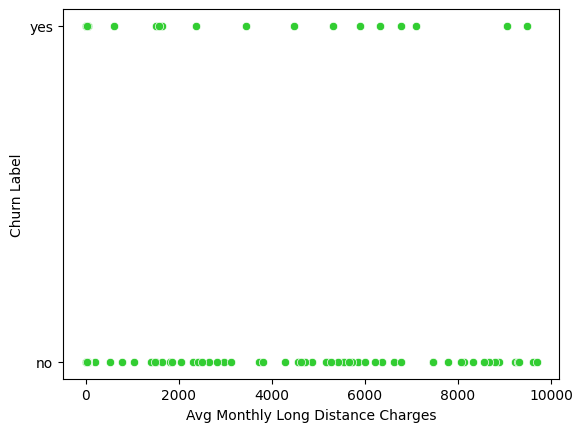

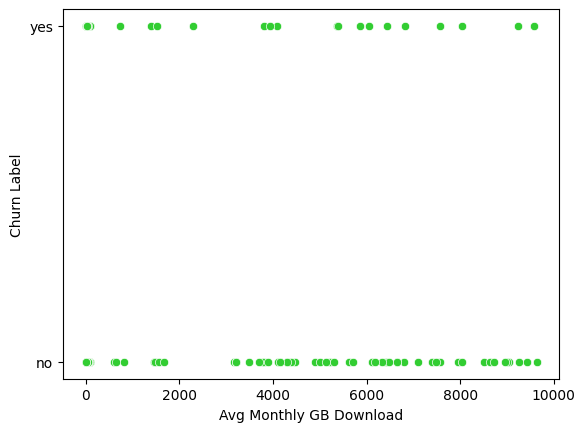

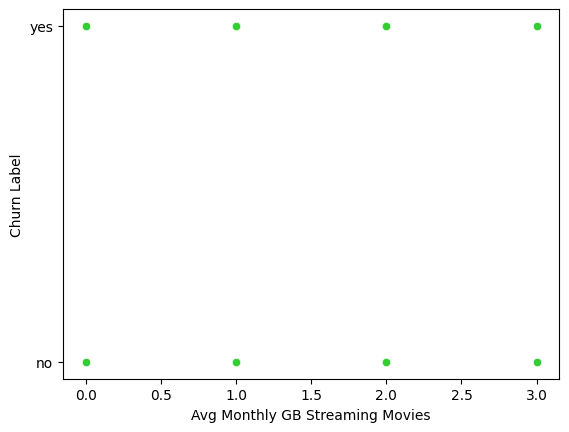

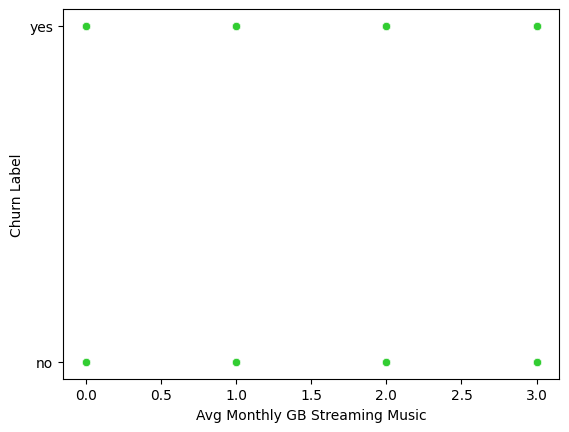

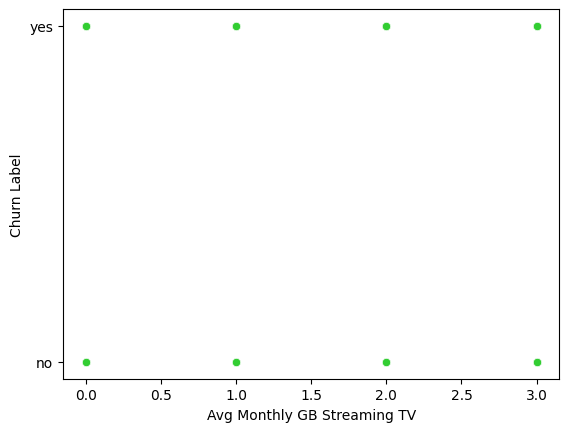

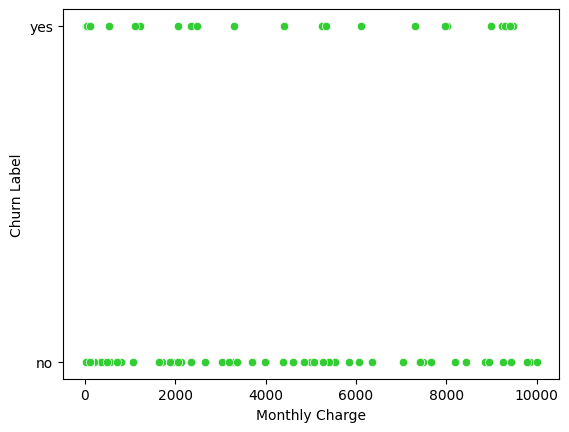

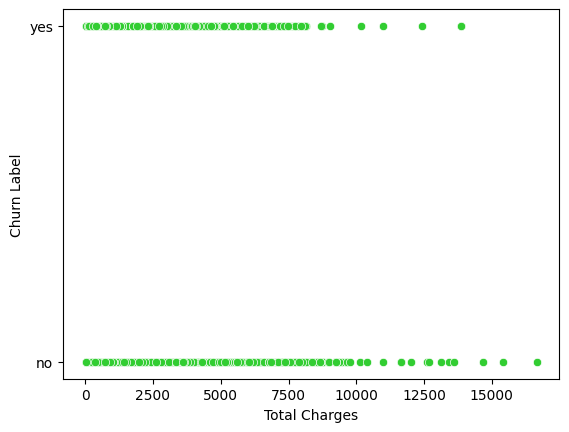

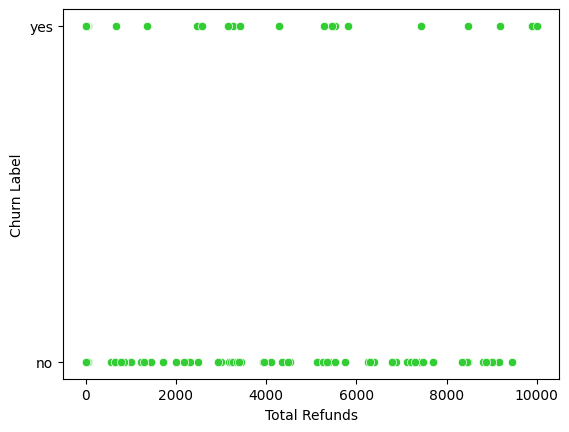

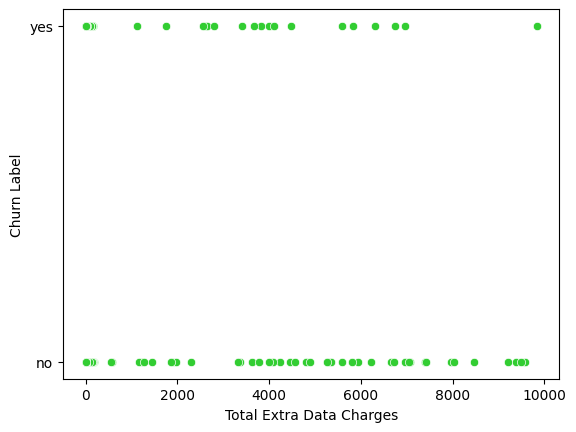

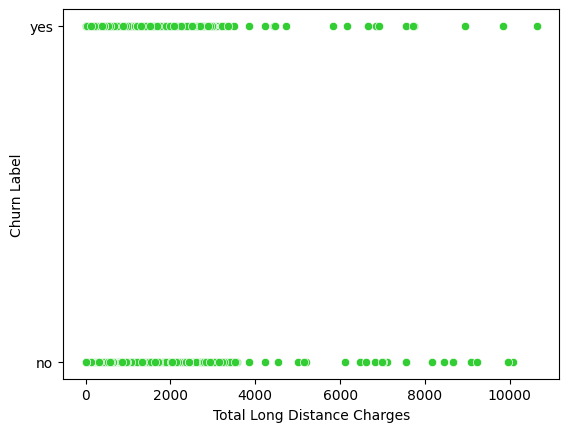

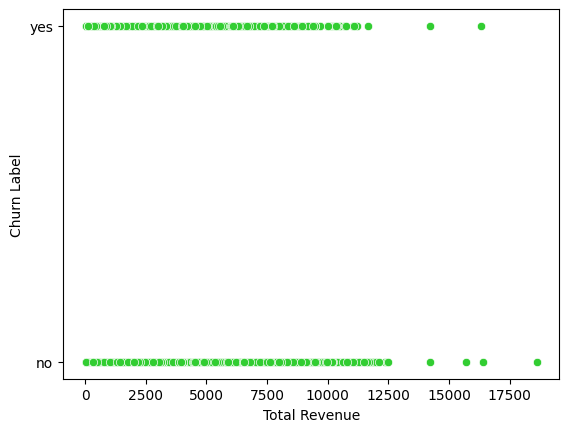

In [ ]:
#dispersão para múltiplas variáveis
for i in dados_descritiva[num_cols]:
  sns.scatterplot(data=dados_descritiva, x=i, y= "Churn Label", color='limegreen')
  plt.show()

#Verificando se existe desbalanceamento na variável resposta

Realmente existe uma diferença entre as quantidades CHURN E NÃO CHURN (devemos ter cuidado com a separação de treino e tete, com as métricas de avaliação, com os hiperparâmetros e com o objetivo do negócio ao qual o modelo se propõe a resolver - tradeoff (RECALL vs PRECISÃO))

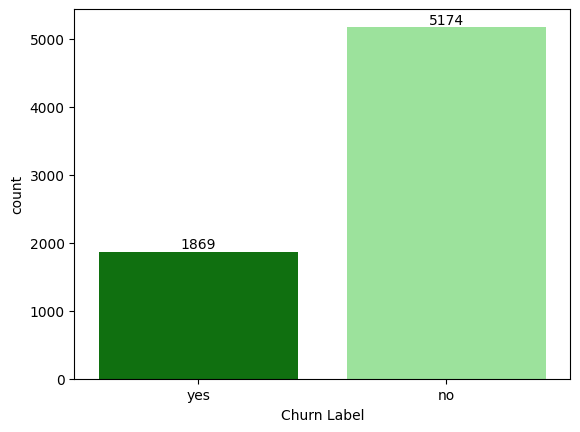

In [ ]:
# verifica se existe desbalanceamento dos dados
palette=['green', 'lightgreen']
ax = sns.countplot(data=dados_descritiva, x='Churn Label', hue='Churn Label', palette=palette)

#rótulos de dados
for p in ax.patches:
    altura = p.get_height()
    ax.text(
        # posição x centralizada
        p.get_x() + p.get_width() / 2.,
        # posição y (acima da barra)
        altura + 0.5,
        # valor da contagem
        int(altura),
        # alinhamento horizontal
        ha='center',
        # alinhamento vertical
        va='bottom'
    )
plt.show()

#Análise bivariada

Frequência de churn por cada categoria - análise extremamente útil

In [ ]:
# verifica a quantidade de cada categoria das variáveis categóricas para o churn e não churn
for i in cat_cols:

  contagem = dados_descritiva.groupby('Churn Label')[i].value_counts(dropna=False)
  print(f'{contagem}\n\n-------------------------\n\n')

Churn Label  sexo     
no           Masculino    2625
             Feminino     2549
yes          Feminino      939
             Masculino     930
Name: count, dtype: int64

-------------------------


Churn Label  Married
no           yes        2733
             no         2441
yes          no         1200
             yes         669
Name: count, dtype: int64

-------------------------


Churn Label  Dependents
no           no            3653
             yes           1521
yes          no            1763
             yes            106
Name: count, dtype: int64

-------------------------


Churn Label  Referred a Friend
no           yes                  2598
             no                   2576
yes          no                   1245
             yes                   624
Name: count, dtype: int64

-------------------------


Churn Label  Phone Service
no           yes              4662
             no                512
yes          yes              1699
             no          

In [ ]:
# verifica a mediana das variáveis numércas para o churn e não churn
for i in num_cols:

  mediana = dados_descritiva.groupby('Churn Label')[i].median()
  print(f'{mediana}\n\n-------------------------\n\n')

Churn Label
no     45.0
yes    50.0
Name: idade, dtype: float64

-------------------------


Churn Label
no     0.0
yes    0.0
Name: Number of Dependents, dtype: float64

-------------------------


Churn Label
no     16377.5
yes    21313.0
Name: Population, dtype: float64

-------------------------


Churn Label
no     1.0
yes    0.0
Name: Number of Referrals, dtype: float64

-------------------------


Churn Label
no     38.0
yes    10.0
Name: Tenure in Months, dtype: float64

-------------------------


Churn Label
no     23.20
yes    23.09
Name: Avg Monthly Long Distance Charges, dtype: float64

-------------------------


Churn Label
no     16.0
yes    19.0
Name: Avg Monthly GB Download, dtype: float64

-------------------------


Churn Label
no     0.0
yes    0.0
Name: Avg Monthly GB Streaming Movies, dtype: float64

-------------------------


Churn Label
no     0.0
yes    0.0
Name: Avg Monthly GB Streaming Music, dtype: float64

-------------------------


Churn Label
no     0.

In [ ]:
# variaveis categoricas
cat_features = dados_descritiva.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
# seleciona variaveis categoricas binarias
resumo_cat = resumo_dataframe(dados_descritiva[cat_features])
variaveis_binarias_to_int = resumo_cat.loc[resumo_cat['Val_unicos'] == 2]['Colunas'].to_list()
variaveis_binarias_to_int

Shape: (7043, 19)





['Married',
 'sexo',
 'Dependents',
 'Referred a Friend',
 'Phone Service',
 'Multiple Lines',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data',
 'Paperless Billing',
 'Churn Label']

In [ ]:
# aplica a função recodificar_colunas o objeto contendo as numericas já foi salvo então não teremos problema com os teste de mann whitney
mapeamentos = {
    'Married': {'yes': 1, 'no': 0},
    'sexo': {'Masculino': 1, 'Feminino': 0},
    'Dependents': {'yes': 1, 'no': 0},
    'Referred a Friend': {'yes': 1, 'no': 0},
    'Phone Service': {'yes': 1, 'no': 0},
    'Multiple Lines': {'yes': 1, 'no': 0},
    'Online Security': {'yes': 1, 'no': 0},
    'Online Backup': {'yes': 1, 'no': 0},
    'Device Protection Plan': {'yes': 1, 'no': 0},
    'Premium Tech Support': {'yes': 1, 'no': 0},
    'Streaming TV': {'yes': 1, 'no': 0},
    'Streaming Movies': {'yes': 1, 'no': 0},
    'Streaming Music': {'yes': 1, 'no': 0},
    'Unlimited Data': {'yes': 1, 'no': 0},
    'Paperless Billing': {'yes': 1, 'no': 0},
    'Churn Label': {'yes': 1, 'no': 0}
}

dados = recodificar_colunas(dados_descritiva, mapeamentos)

# Métodos básicos - Testes estatísticos (Qui quadrado e T Student) e a medida V de Cramer

Separando os tipos de variáveis em listas para serem utilizadas nos teste estatísticos

Teste Qui quadrado de independência

In [ ]:
cat_cols

['sexo',
 'Married',
 'Dependents',
 'Referred a Friend',
 'Phone Service',
 'Multiple Lines',
 'Internet Type',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data',
 'Contract',
 'Paperless Billing',
 'Payment Method']

In [ ]:
# aplica a função Qui2
df_analise = Qui2(dados_descritiva, cat_cols)
print(df_analise)

                  Variável       Chi2  p-valor             Status  \
1                  Married   158.7334   0.0000    DEPENDENTE (H1)   
2               Dependents   433.7344   0.0000    DEPENDENTE (H1)   
3        Referred a Friend   155.9403   0.0000    DEPENDENTE (H1)   
7          Online Security   205.6331   0.0000    DEPENDENTE (H1)   
6            Internet Type   412.6165   0.0000    DEPENDENTE (H1)   
10    Premium Tech Support   190.1668   0.0000    DEPENDENTE (H1)   
9   Device Protection Plan    30.5134   0.0000    DEPENDENTE (H1)   
8            Online Backup    47.2609   0.0000    DEPENDENTE (H1)   
12        Streaming Movies    26.2513   0.0000    DEPENDENTE (H1)   
14          Unlimited Data   194.5492   0.0000    DEPENDENTE (H1)   
15                Contract  1445.2932   0.0000    DEPENDENTE (H1)   
11            Streaming TV    27.8625   0.0000    DEPENDENTE (H1)   
17          Payment Method   337.8312   0.0000    DEPENDENTE (H1)   
16       Paperless Billing   258.2

Verificando a intesidade das variáveis utilizadas no teste Qui quadrado

In [ ]:
# aplica a função analisar_intensidade_chi2
resultados_intensidade = analisar_intensidade_chi2(dados_descritiva, cat_cols)
print(resultados_intensidade)

                  Variável  p-valor  V de Cramer  Intensidade  \
15                Contract   0.0000       0.4530     Moderada   
6            Internet Type   0.0000       0.2605        Fraco   
2               Dependents   0.0000       0.2482        Fraco   
17          Payment Method   0.0000       0.2190        Fraco   
16       Paperless Billing   0.0000       0.1915        Fraco   
7          Online Security   0.0000       0.1709        Fraco   
14          Unlimited Data   0.0000       0.1662        Fraco   
10    Premium Tech Support   0.0000       0.1643        Fraco   
1                  Married   0.0000       0.1501        Fraco   
3        Referred a Friend   0.0000       0.1488        Fraco   
8            Online Backup   0.0000       0.0819  Desprezível   
9   Device Protection Plan   0.0000       0.0658  Desprezível   
11            Streaming TV   0.0000       0.0629  Desprezível   
12        Streaming Movies   0.0000       0.0611  Desprezível   
13         Streaming Musi

Teste Mann Whitey (não paramétrico e mais robusto a outliers por utilizar a mediana) não precis ada normalidade dos dados

In [ ]:
# teste Mann whitney robusto a outliers
df_resumo_num_mann = mannwhitney(dados_descritiva, num_cols, target='Churn Label', alpha=0.05, alternative='two-sided')
df_resumo_num_mann


,Variável,p-valor,Correlação (PB ranks),Intensidade,Influencia Churn?
0,idade,0.0000,0.1089,Baixa,Sim
1,Number of Dependents,0.0000,-0.2451,Baixa,Sim
2,Population,0.0000,0.0545,Desprezível,Sim
3,Number of Referrals,0.0000,-0.2319,Baixa,Sim
4,Tenure in Months,0.0000,-0.3683,Moderada,Sim
5,Avg Monthly GB Download,0.0000,0.1076,Baixa,Sim
6,Monthly Charge,0.0000,0.1813,Baixa,Sim
7,Total Charges,0.0000,-0.2297,Baixa,Sim
8,Total Long Distance Charges,0.0000,-0.2324,Baixa,Sim
9,Total Revenue,0.0000,-0.2638,Baixa,Sim


Matriz de correlação (verifica a possibilidade de multicolinearidade sobre o modelo de regressão logística)

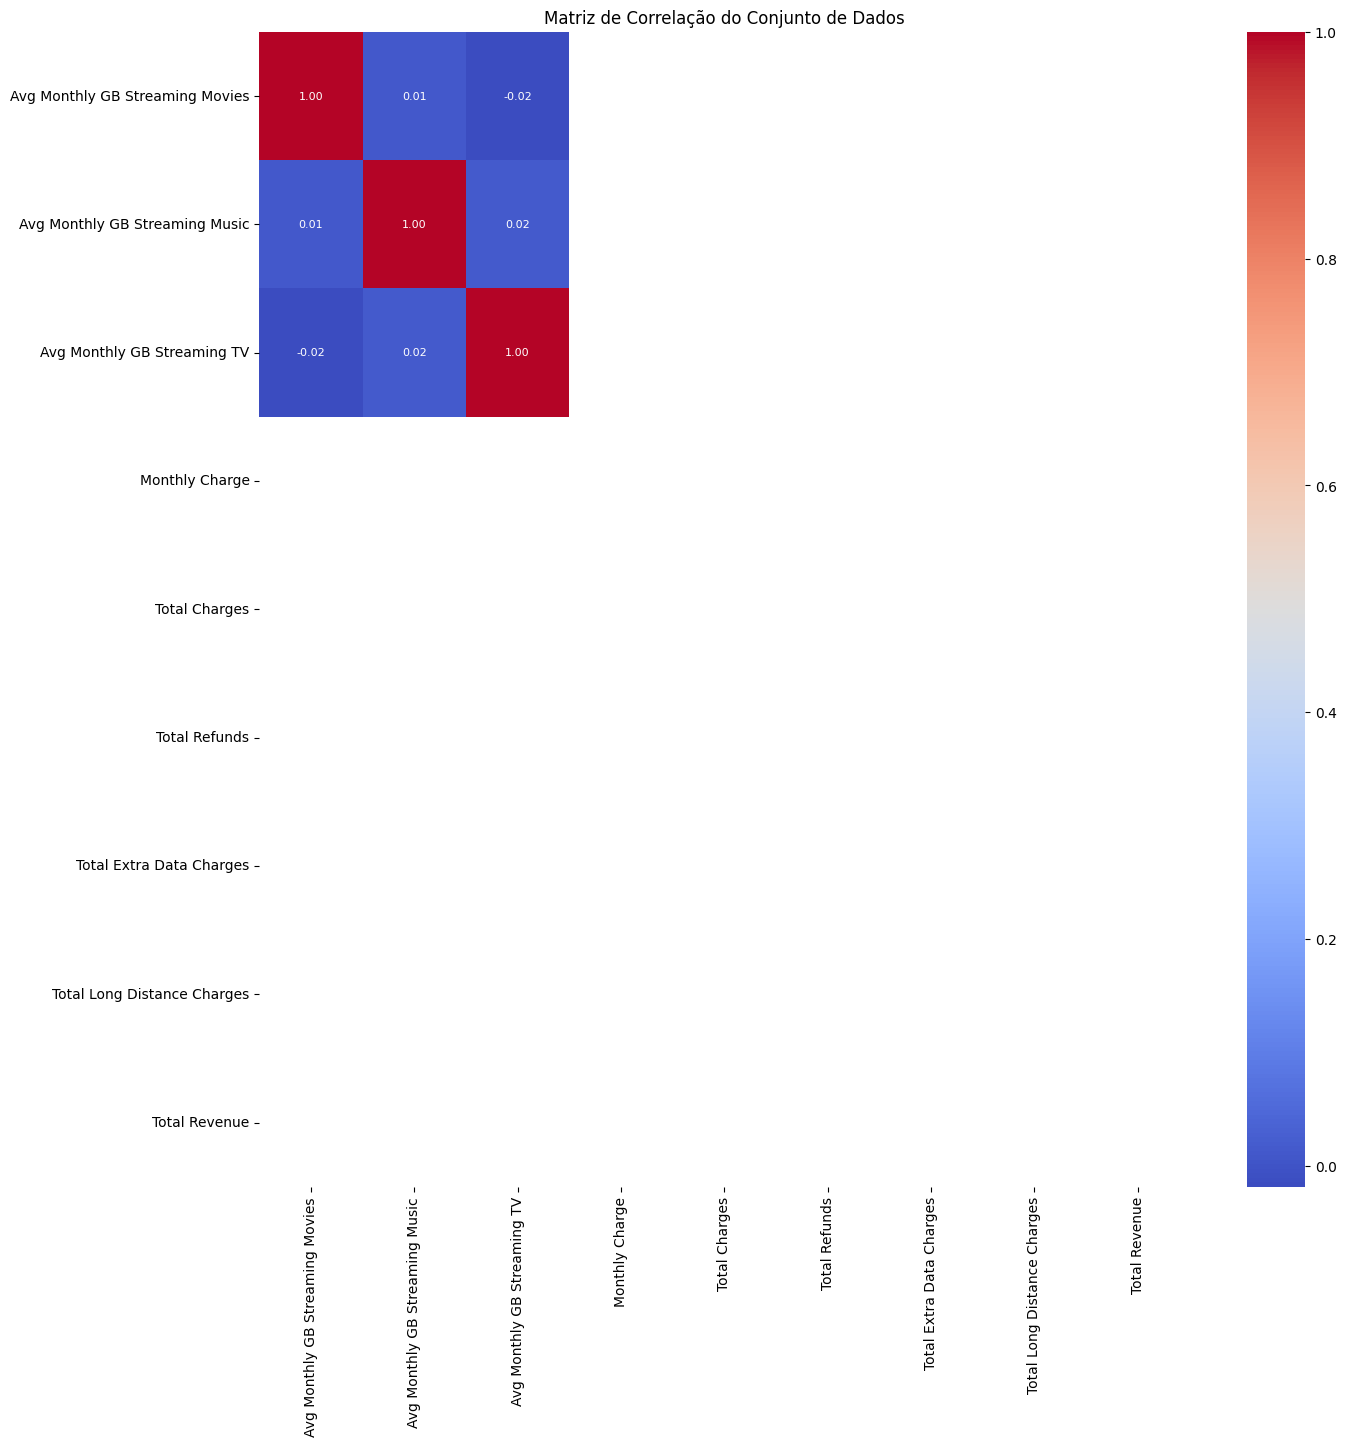

In [ ]:
# normaliza os recursos
num_features_corr = dados_descritiva.select_dtypes(include=['int64', 'float64']).columns.tolist()
cols_para_remover = ['Latitude', 'Zip Code', 'Longitude', 'Number of Dependents', 'idade', 'Population',\
                     'Number of Referrals', 'Churn Label', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download']
# mantém apenas o que NÃO estiver na lista de remoção
num_features_corr = [col for col in num_features_corr if col not in cols_para_remover]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(dados_descritiva[num_features_corr])


# calcula matriz de correlação
corr_matrix = np.corrcoef(X_scaled.T)

# cria heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=num_features_corr, yticklabels=num_features_corr, fmt=".2f", annot_kws={"size": 8})
plt.title('Matriz de Correlação do Conjunto de Dados')
plt.show()

#PIPELINE DE TRATAMENTO DE DADOS

Definindo os dados utilizados no modelo

In [ ]:
colunas_removidas, dados_modelo = remover_colunas_com_muitos_nulos(dados_brutos, limite=0.2)

print(f"Após remoção de nulos, dataset tem {dados_modelo.shape[1]} colunas")

# remove colunas que não serão usadas no modelo (de forma segura)
cols_remover = ['Zip Code', 'Customer ID', 'Churn Score', 'Customer Status', 'City', 'Country', 'State', 'Quarter', 'Latitude', 'Longitude']

# verifica quais colunas ainda existem
print(f"Colunas disponíveis antes: {dados_modelo.columns.tolist()}")

# remove as colunas
dados_modelo = dados_modelo.drop(columns=cols_remover, errors='ignore')

print(f"Após remoção manual, dataset tem {dados_modelo.shape[1]} colunas")

# mostra quais colunas restaram
print(f"Colunas disponíveis antes: {dados_modelo.columns.tolist()}")

Após remoção de nulos, dataset tem 45 colunas
Colunas disponíveis antes: ['Customer ID', 'Gender', 'Age', 'Married', 'Dependents', 'Number of Dependents', 'Country', 'State', 'City', 'Zip Code', 'Latitude', 'Longitude', 'Population', 'Quarter', 'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines', 'Internet Type', 'Avg Monthly GB Download', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Avg Monthly GB Streaming Movies', 'Avg Monthly GB Streaming Music', 'Avg Monthly GB Streaming TV', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Customer Status', 'Churn Label', 'Churn Score']
Após remoção manual, dataset tem 35 colunas
Colunas disponíveis antes: ['Gender', 'Age',

Separação entre treino/validação e teste (para evitar #data leakage)

In [ ]:
# separa os dados em conjuntos de treinamento/validação e teste estratificando pela variável resposta (mantendo as proporções para variável desbalanceada)

# separa features e target
X = dados_modelo.drop(columns=['Churn Label'], axis=1)
y = dados_modelo['Churn Label']

# recoda a variável resposta
y = y.str.lower()
le = LabelEncoder()
# yes=1, no=0
y = pd.Series(le.fit_transform(y), index=dados_modelo.index)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# proporcao da variável resposta por base
y_train_prop = y_train.mean()
y_test_prop = y_test.mean()


print(f'Treino: {y_train_prop}\n\n')
print(f'Teste: {y_test_prop}')

Treino: 0.2653532126375577


Teste: 0.2654364797728886


#PIPELINE DA VALIDAÇÃO CRUZADA DOS MODELOS XGBOOST, LIGHTGBM, RANDOM FOREST, LOGISTIC

Separa as numéricas e as categóricas

In [ ]:
# separa as variáveis numéricas e categóricas
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# quantidade de numéricas e categóricas(nominais ou ordinais)
print(f"Número de features numéricas: {len(num_features)}")
print(f"Número de features categóricas: {len(cat_features)}")

Número de features numéricas: 16
Número de features categóricas: 18


Separando as variáveis categóricas binárias das não binárias

Definição final dos objetos contendo os tipo variáveis para inserir na pipeline

In [ ]:
# separa as variáveis numéricas que passaram por tratamento de outliers por erro de imputação
num_features_IQR = ['Age', 'Ternure in Months', 'Number of Dependents', 'Number of Referrals']

# filtra apenas colunas que realmente existem
num_features_com_IQR = [col for col in num_features_IQR if col in num_features]

# remove as com IQR da lista geral de numéricas
num_features_sem_IQR = [col for col in num_features if col not in num_features_com_IQR]

print(f"Numéricas com IQR: {num_features_com_IQR}")
print(f"Numéricas sem IQR: {num_features_sem_IQR}")

Numéricas com IQR: ['Age', 'Number of Dependents', 'Number of Referrals']
Numéricas sem IQR: ['Population', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Avg Monthly GB Streaming Movies', 'Avg Monthly GB Streaming Music', 'Avg Monthly GB Streaming TV', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue']


In [ ]:
# tranformer para tratar os outliers
class IQRWinsorizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, k=1.5):
        self.k = k
        self.lower_bounds_ = None
        self.upper_bounds_ = None

    def fit(self, X, y=None):
        # X é um numpy array (não DataFrame) quando vem do ColumnTransformer

        # Calcular quartis e limites com base nos dados de treino
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1

        # salva os limites para usar no transform em todos os dados
        self.lower_bounds_ = Q1 - self.k * IQR
        self.upper_bounds_ = Q3 + self.k * IQR

        return self

    def transform(self, X):
        X_copy = X.copy()

        # aplica a winsorização nas variáveis
        for i in range(X_copy.shape[1]):
            X_copy[:, i] = np.clip(X_copy[:, i],
                                  self.lower_bounds_[i],
                                  self.upper_bounds_[i])

        return X_copy

    def get_feature_names_out(self, input_features=None):
        # para nomear as variáveis no pipeline
        return input_features

In [ ]:
class TextLowercaseTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Para cada coluna (feature) no array
        for col_idx in range(X_copy.shape[1]):
            # Extrair a coluna
            col_data = X_copy[:, col_idx]

            # Criar máscara de não-NaN
            mask = ~pd.isna(col_data)

            if np.any(mask):
                # Aplicar lowercase apenas nos valores não NaN
                # Converter para string primeiro
                non_nan_values = col_data[mask].astype(str)

                # Aplicar lowercase e strip
                lower_values = np.char.lower(non_nan_values)
                lower_values = np.char.strip(lower_values)

                # Atualizar valores na cópia
                col_data_copy = col_data.copy()
                col_data_copy[mask] = lower_values
                X_copy[:, col_idx] = col_data_copy

        return X_copy

    def get_feature_names_out(self, input_features=None):
        return input_features

In [ ]:
# pipeline para as variáveis categóricas
pipeline_ohe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('lowercase', TextLowercaseTransformer()),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# pipeline para as variáveis numéricas com tratamento de outliers (IQR)
pipeline_num_com_IQR = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('outlier', IQRWinsorizerTransformer(k=1.5)),
    ('scaler', StandardScaler())
])

# pipeline para numéricas sem tratamento de outliers
pipeline_num_sem_IQR = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

In [ ]:
# columntransformer com as três pipelines criadas
pre_processamento = ColumnTransformer(transformers=[
    ('ohe', pipeline_ohe, cat_features),
    ('num_com_iqr', pipeline_num_com_IQR, num_features_com_IQR),
    ('num_sem_iqr', pipeline_num_sem_IQR, num_features_sem_IQR)
])

In [ ]:
# adiciona o balanceamento para a classe minoritária
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        solver="lbfgs",
        random_state=42,
        # ajuste dos pesos
        class_weight='balanced'
    ),

    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ),

    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="auc",
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        # truque interessante
        scale_pos_weight=...
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
}

In [ ]:
results = []

# dicionário contendo as métricas de avaiação do modelo
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# calcula scale_pos_weight para o modelo de XGBoost
if 'y_train' in locals():
    negative_count = (y_train == 0).sum()
    positive_count = (y_train == 1).sum()
    scale_pos_weight = negative_count / positive_count
    print(f"scale_pos_weight calculado: {scale_pos_weight:.2f}")

    # atualiza o XGBoost
    models["XGBoost"].set_params(scale_pos_weight=scale_pos_weight)

for name, model in models.items():
    print(f"\nTreinando {name}...")

    # pipeline completo pré processamento e modelagem
    pipeline = Pipeline(steps=[
        ('pre_processamento', pre_processamento),
        ('modelo', model)
    ])


    # etapa de validação cruzada
    scores = cross_validate(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        verbose=0
    )

    result_row = {"modelo": name}

    for metric in scoring.keys():
        result_row[f"{metric}_mean"] = scores[f"test_{metric}"].mean()
        result_row[f"{metric}_std"] = scores[f"test_{metric}"].std()

    results.append(result_row)

# resultados
results_df = (
    pd.DataFrame(results)
    .sort_values("roc_auc_mean", ascending=False)
    .reset_index(drop=True)
)

results_df

scale_pos_weight calculado: 2.77

Treinando LogisticRegression...

Treinando RandomForest...

Treinando XGBoost...

Treinando LightGBM...


,modelo,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
0,XGBoost,0.833507,0.011970,0.665205,0.021457,0.751171,0.027950,0.705353,0.020991,0.899198,0.005519
1,LightGBM,0.831912,0.009699,0.663192,0.015899,0.745151,0.032177,0.701511,0.019697,0.897981,0.004918
2,RandomForest,0.840611,0.008939,0.757047,0.016268,0.587960,0.035734,0.661369,0.025709,0.895987,0.006445
3,LogisticRegression,0.779195,0.009144,0.556294,0.012368,0.832776,0.010786,0.666933,0.010269,0.885150,0.001504


#Modelo já selecionado via validação cruzada

Pipeline final considerando o modelo XGBOOST como o campeão (RECALL: 0.73 | PRECISÃO: 0.65)

In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

pipe_final = Pipeline(steps=[
    ('pre_processamento', pre_processamento),
    ('model', XGBClassifier(
        objective='binary:logistic',
        # ideal para problemas de dados desbalanceados xgboost eval_metric não aceita o recall
        eval_metric='aucpr',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    ))
])

# dicionário de hiperparâmetros para o tunning
param_grid = {
    'model__n_estimators': [200, 300, 400],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 0.9],
    'model__reg_alpha': [0, 0.1, 1, 5],
    'model__reg_lambda': [1, 3, 5]
}

# random search para tunning aleatório dos hiper paramêtros
model = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    # foco do projeto
    scoring='recall',
    refit='recall',
    verbose=1,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# ajuste do modelo na base de treino
model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:54:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre_processamento',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('lowercase',
                                                                                                TextLowercaseTransformer()),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Gender',
                                                                                'Married',
                                                                                'Dependents',
                                                                                'Referred '
                                                                                'a '
                                                                                'Friend',
                                                                                'Ph...
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.7, 0.8,
                                                                    0.9],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [3, 5, 7],
                                        'model__n_estimators': [200, 300, 400],
                                        'model__reg_alpha': [0, 0.1, 1, 5],
                                        'model__reg_lambda': [1, 3, 5],
                                        'model__subsample': [0.7, 0.8, 0.9]},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring='recall', verbose=1)

In [ ]:
# pega o melhor modelo após o tunning
best_model = model.best_estimator_


print("RESULTADOS DO RANDOMIZED SEARCH CV")

# melhor recall no (cross-validation)
print(f"Melhor RECALL (validação cruzada): {model.best_score_:.4f}")

# RECALL na base de treino (usando o melhor modelo refitado)
print(f"RECALL no conjunto de treino: {model.score(X_train, y_train):.4f}")

# pedições na base de treino
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:, 1]

print(f"\nMétricas no TREINO (melhor modelo):")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_train, y_train_proba):.4f}")

# melhores parâmetros
print(f"\nMelhores parâmetros encontrados:")
for param, value in model.best_params_.items():
    print(f"  {param}: {value}")

RESULTADOS DO RANDOMIZED SEARCH CV
Melhor RECALL (validação cruzada): 0.8482
RECALL no conjunto de treino: 0.8829

Métricas no TREINO (melhor modelo):
  Accuracy:  0.8211
  Precision: 0.6131
  Recall:    0.8829
  ROC-AUC:   0.9249

Melhores parâmetros encontrados:
  model__subsample: 0.7
  model__reg_lambda: 5
  model__reg_alpha: 0.1
  model__n_estimators: 200
  model__max_depth: 5
  model__learning_rate: 0.01
  model__colsample_bytree: 0.8


# Matriz de confusão com o ponto de corte interativo!

In [ ]:
# função para a definição da matriz de confusão
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score

def matriz_confusao(predicts, observado, cutoff, custo_fp=100, custo_fn=1000):
    values = predicts.values
    predicao_binaria = []
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
    cm = confusion_matrix(predicao_binaria, observado)
    tn, fp, fn, tp = confusion_matrix(observado, predicao_binaria, labels=[0, 1]).ravel()
    prejuizo = (fp * custo_fp) + (fn * custo_fn)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('Observado')
    plt.ylabel('Predito')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()

    acuracia = accuracy_score(observado, predicao_binaria)
    precisao = precision_score(observado, predicao_binaria)
    recall = recall_score(observado, predicao_binaria)
    F1 = f1_score(observado, predicao_binaria)


    # visualização dos principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Acurácia':[acuracia],
                                'Precisão':[precisao],
                                'Recall':[recall],
                                'F1':[recall],
                                'Prejuízo': [prejuizo]})
    return indicadores

#Esta matriz possui ponto de corte interativo ideal para realização de testes

#essa matriz retorna o prejuízo com base na lógica interna

# falso negativo = -100 reais
# verdadeiro positivo = 10 reais

# valores meramente para testes podendo ser alterados para a realidade do negócio

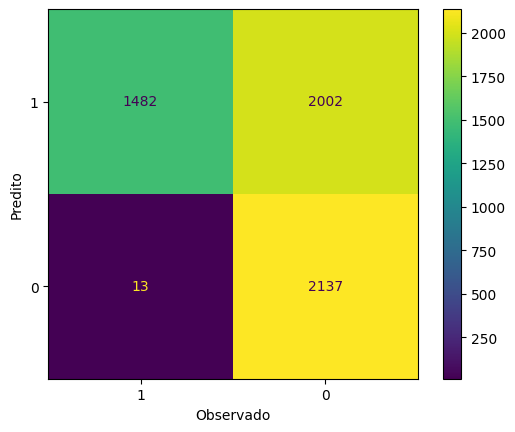

,Acurácia,Precisão,Recall,F1,Prejuízo
0,0.64235,0.425373,0.991304,0.991304,213200


In [ ]:
# dataframe de previsao para a matriz de confusão
confusao_df_train = pd.DataFrame({'observado': y_train, 'predito': y_train_proba})

# matriz de confusão para cutoff = X
matriz_confusao(observado= confusao_df_train['observado'],
                predicts= confusao_df_train['predito'], cutoff=0.2, custo_fp=100, custo_fn=1000)

In [ ]:
# avalia o modelo no treino
print("\nRelatório de Classificação:\n", classification_report(y_train, y_train_pred))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87      4139
           1       0.61      0.88      0.72      1495

    accuracy                           0.82      5634
   macro avg       0.78      0.84      0.80      5634
weighted avg       0.86      0.82      0.83      5634



AUC: 0.9249135194143965


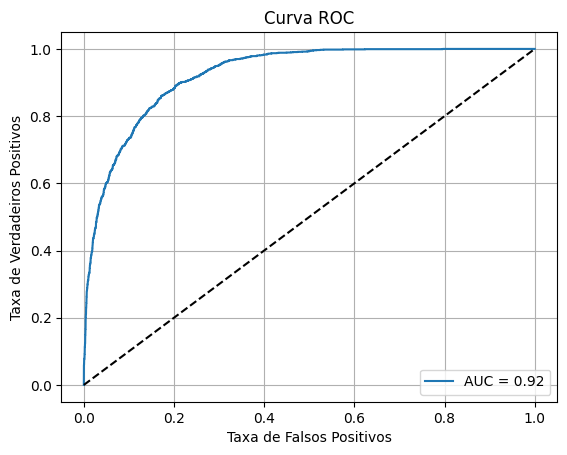

In [ ]:
# curva ROC e AUC
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_train_proba)
auc_train = roc_auc_score(y_train, y_train_proba)
print("AUC:", auc_train)

plt.plot(fpr_train, tpr_train, label=f'AUC = {auc_train:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

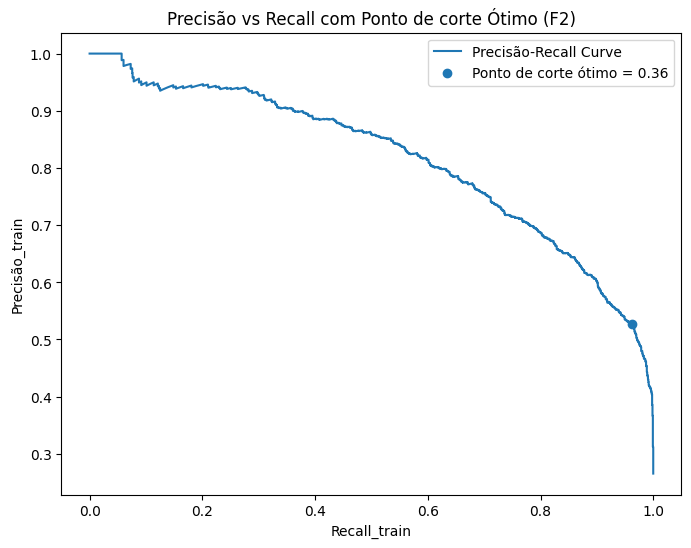

In [ ]:
# curva precisão vs Recall
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_proba)

# F2-score (prioriza recall, ideal para churn)
f2_scores = (5 * precision_train * recall_train) / (4 * precision_train + recall_train + 1e-9)

# ponto de corte
best_idx = np.argmax(f2_scores)
best_threshold = thresholds_train[best_idx]

# plot
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label="Precisão-Recall Curve")
plt.scatter(
    recall_train[best_idx],
    precision_train[best_idx],
    label=f"Ponto de corte ótimo = {best_threshold:.2f}"
)

plt.xlabel("Recall_train")
plt.ylabel("Precisão_train")
plt.title("Precisão vs Recall com Ponto de corte Ótimo (F2)")
plt.legend()
plt.show()


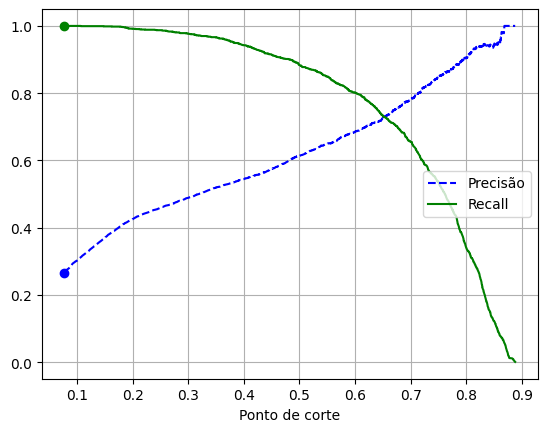

In [ ]:
# gera o gráfico PR
def plot_precision_recall_vs_threshold(precision, recall, thresholds):
    plt.plot(thresholds, precision[:-1], "b--", label="Precisão")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    # plt.vlines(thresholds, 0, 1.0, "k", "dotted", label="threshold")
    # first index ≥ threshold
    idx = (thresholds >= thresholds).argmax()
    plt.plot(thresholds[idx], precision[idx], "bo")
    plt.plot(thresholds[idx], recall[idx], "go")
    #plt.axis([-50000, 50000, 0, 1])
    plt.grid()
    plt.xlabel("Ponto de corte")
    plt.legend(loc="center right")

# plota o gráfico PR
plot_precision_recall_vs_threshold(precision_train, recall_train, thresholds_train)
plt.show()

# Predições na base de Teste

Avaliação no conjunto de teste
Acurácia:  0.8034
Precisão: 0.5900
Recall:    0.8503
ROC-AUC:   0.9060

Matriz de Confusão:
  Verdadeiros Negativos: 814
  Falsos Positivos:      221
  Falsos Negativos:      56
  Verdadeiros Positivos: 318


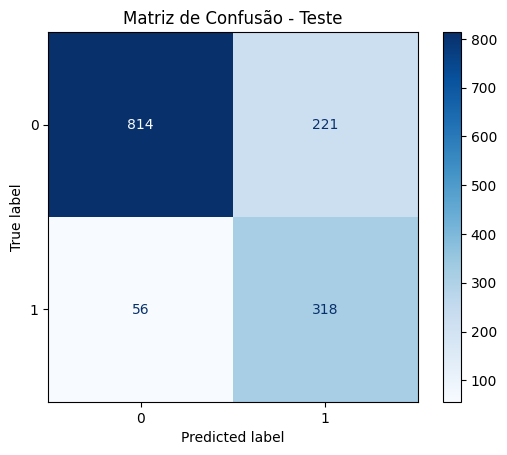

In [ ]:
# avaliação no teste
print("Avaliação no conjunto de teste")

# previsões no teste
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Acurácia:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_proba):.4f}")

# matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nMatriz de Confusão:")
print(f"  Verdadeiros Negativos: {cm[0, 0]}")
print(f"  Falsos Positivos:      {cm[0, 1]}")
print(f"  Falsos Negativos:      {cm[1, 0]}")
print(f"  Verdadeiros Positivos: {cm[1, 1]}")

# visualizar matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Teste')
plt.show()

# Matriz de confusão no teste (ponto de corte ajustável)

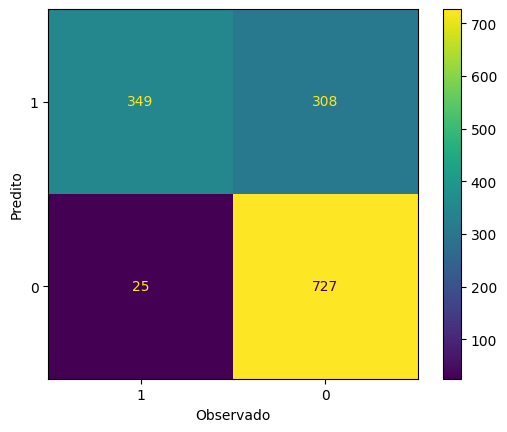

,Acurácia,Precisão,Recall,F1,Prejuízo
0,0.763662,0.531202,0.933155,0.933155,55800


In [ ]:
# dataframe de previsao para a matriz de confusão
confusao_df_test = pd.DataFrame({'observado': y_test, 'predito': y_test_proba})

# Matrizes de confusão propriamente ditas

# matriz de confusão para cutoff = 0.5
matriz_confusao(observado= confusao_df_test['observado'],
                predicts= confusao_df_test['predito'],
                cutoff=0.4)

# Matriz de confusão no treino (Ponto de corte ajustável)

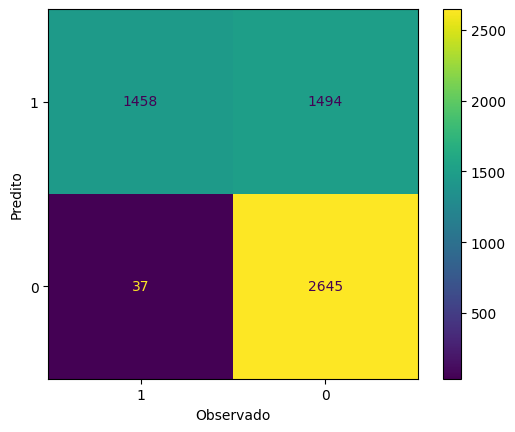

,Acurácia,Precisão,Recall,F1,Prejuízo
0,0.728257,0.493902,0.975251,0.975251,186400


In [ ]:
# dataframe de previsao para a matriz de confusão
confusao_df_train = pd.DataFrame({'observado': y_train, 'predito': y_train_proba})

# matriz de confusão para cutoff = X
matriz_confusao(observado= confusao_df_train['observado'],
                predicts= confusao_df_train['predito'], cutoff=0.31, custo_fp=100, custo_fn=1000)

# Verificando as métricas para avaliar um possivel overfitting

Métricas de teste

In [ ]:
# avalia o modelo
print("\nRelatório de Classificação:\n", classification_report(y_test, y_test_pred))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.79      0.85      1035
           1       0.59      0.85      0.70       374

    accuracy                           0.80      1409
   macro avg       0.76      0.82      0.78      1409
weighted avg       0.84      0.80      0.81      1409



Métricas de treino

In [ ]:
# avalia o modelo no treino
print("\nRelatório de Classificação:\n", classification_report(y_train, y_train_pred))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87      4139
           1       0.61      0.88      0.72      1495

    accuracy                           0.82      5634
   macro avg       0.78      0.84      0.80      5634
weighted avg       0.86      0.82      0.83      5634



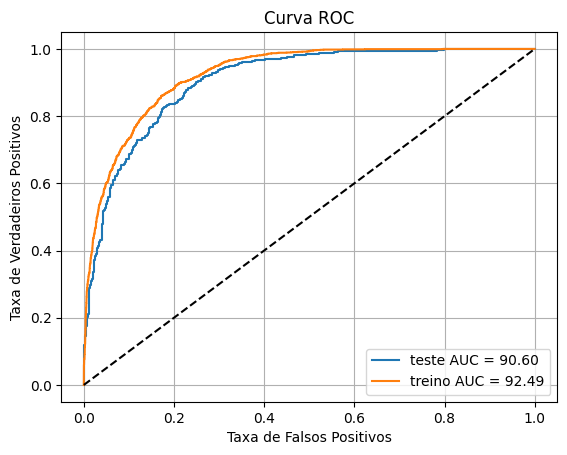

In [ ]:
# curva ROC e AUC
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

plt.figure(dpi=100)

plt.plot(fpr_test, tpr_test, label=f'teste AUC = {100*auc_test:.2f}')
plt.plot(fpr_train, tpr_train, label=f'treino AUC = {100*auc_train:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

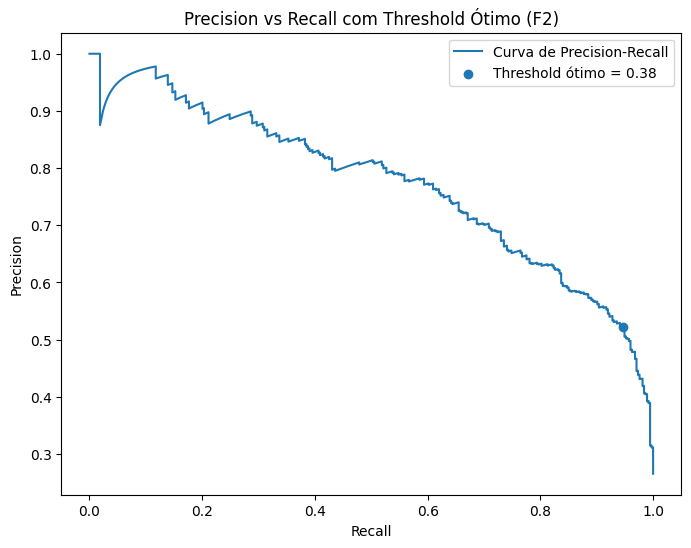

In [ ]:
# curva Precisão-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

# F2-score (prioriza recall, ideal para churn)
f2_scores = (5 * precision * recall) / (4 * precision + recall + 1e-9)

# ponto de corte ótimo
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]

# plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Curva de Precision-Recall")
plt.scatter(
    recall[best_idx],
    precision[best_idx],
    label=f"Threshold ótimo = {best_threshold:.2f}"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall com Threshold Ótimo (F2)")
plt.legend()
plt.show()

#SHAP - avaliação das variáveis

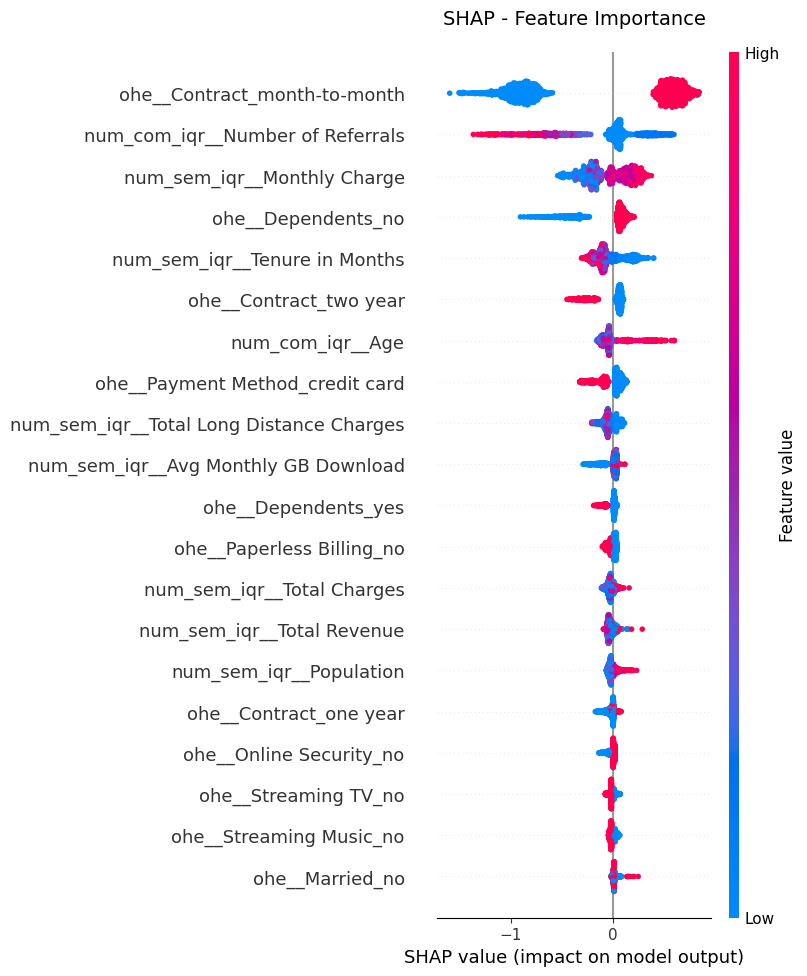

In [ ]:
# melhor modelo
best_pipeline = model.best_estimator_
# puxa o pipeline de pre processamento
preprocessor = best_pipeline.named_steps["pre_processamento"]
# puxa o modelo
xgb_model = best_pipeline.named_steps["model"]
# transforma as variáveis via pipeline puxada
X_test_transformed = preprocessor.transform(X_test)
# puxa os nomes das variáveis explicativas pós pre processamento (poderia haver troca de nomes ex: Age -> idade)
feature_names = preprocessor.get_feature_names_out()
# estima a árvore
explainer = shap.TreeExplainer(xgb_model)
# calcula os valores de shap com base nos dados de teste
shap_values = explainer.shap_values(X_test_transformed)

if isinstance(shap_values, list):
  # classe positiva (churn)
    shap_values = shap_values[1]

# SHAP summary com mais detalhes
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="dot",
    #mostra as top 20 variáveis segundo o SHAP
    max_display=20,
    show=False
)

plt.title("SHAP - Feature Importance", fontsize=14, pad=20)
# plt.tight_layout()
plt.show()


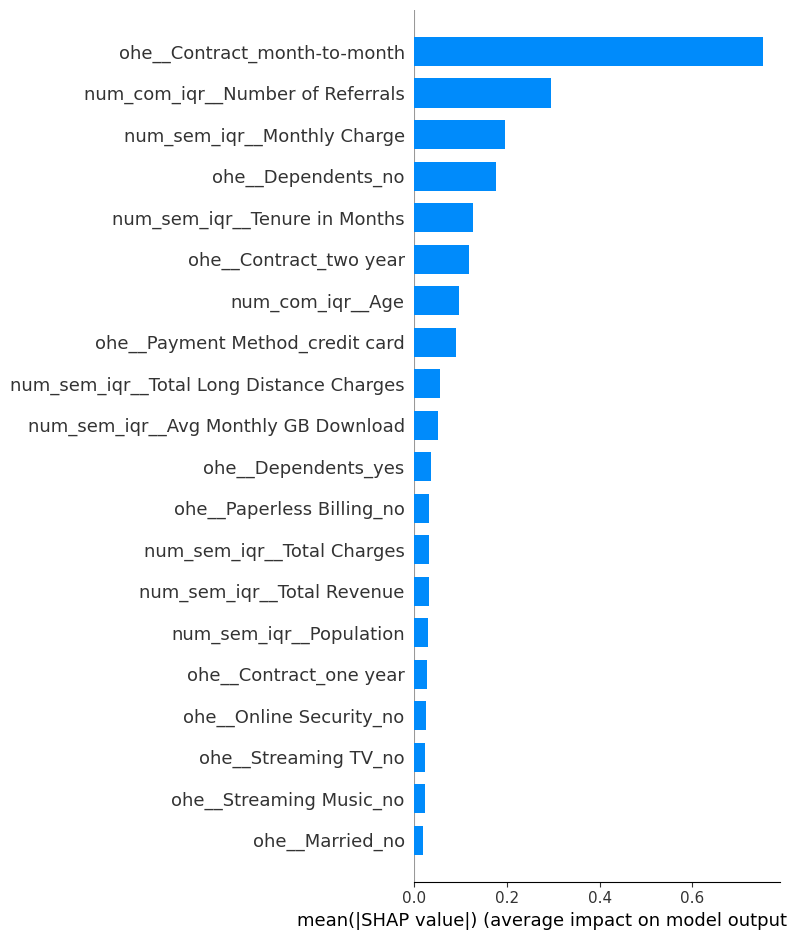

In [ ]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="bar"
)